# EBM Sampler pluging to feasibility decoder

This notebook takes a trained Energy-Based Model (EBM) and the designed Normalized Temporal Temporal Langevin Sampler to generate candidates relaxed binaries for a hierarchical feasibility decoder that enforces feasibility before pluging the outputs into a LP solver.

## Hardware Requirements
- **GPU**: A100 (40 or 80 GB VRAM)
- **RAM**: 50+ GB (High RAM runtime)
- **Storage**: 100+ GB on Drive

## Setup
1. Upload your `benchmark` repo to Google Drive
2. Select Runtime → Change runtime type → A100 GPU + High RAM
3. Run cells in order

---

## 1. Mount Google Drive and Setup Paths

In [1]:
# Mount Google Drive
from google.colab import drive
import os
import sys

drive.mount('/content/drive', force_remount=True)

# Set paths - ADJUST THIS to match your Drive structure
REPO_PATH = '/content/drive/MyDrive/benchmark'
EMBEDDING_FILE = 'outputs/encoders/hierarchical_temporal/embeddings_multiscale_normalized.pt'
EMBEDDING_ZONE_FILE = 'outputs/encoders/hierarchical_temporal/embeddings_zone.pt'
SCENARIOS_DIR = 'outputs/scenarios_v1_filtered'
SCENARIO_DIR_EVAL = 'outputs/scenarios_v1/eval'
OUTPUT_DIR = 'outputs/ebm_models'

# Add repo to Python path
sys.path.insert(0, REPO_PATH)

# Verify paths exist
print(f"Repo path: {REPO_PATH}")
print(f"Repo exists: {os.path.exists(REPO_PATH)}")
print(f"Embeddings path: {os.path.join(REPO_PATH, EMBEDDING_FILE)}")
print(f"Embeddings exist: {os.path.exists(os.path.join(REPO_PATH, EMBEDDING_FILE))}")
print(f"Embeddings zone exist: {os.path.exists(os.path.join(REPO_PATH, EMBEDDING_ZONE_FILE))}")
print(f"Scenarios exist: {os.path.exists(os.path.join(REPO_PATH, SCENARIOS_DIR))}")
print(f"Scenario EVAL: {os.path.exists(os.path.join(REPO_PATH, SCENARIO_DIR_EVAL))}")

Mounted at /content/drive
Repo path: /content/drive/MyDrive/benchmark
Repo exists: True
Embeddings path: /content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal/embeddings_multiscale_normalized.pt
Embeddings exist: True
Embeddings zone exist: True
Scenarios exist: True
Scenario EVAL: True


## 2. Install Dependencies

In [2]:
# Install required packages
# !pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install -q torch-geometric torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
# !pip install -q wandb tqdm pandas numpy scipy

import torch

print("🔄 Installing PyTorch 2.5.1 and PyTorch Geometric...")

# Uninstall existing packages to ensure a clean slate
!pip uninstall -y torch torchvision torchaudio torch-scatter torch-sparse torch-geometric

# Install PyTorch 2.5.1 + CUDA 12.4
!pip install -q torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1+cu124 --index-url https://download.pytorch.org/whl/cu124

# Install PyG dependencies with matching wheels
!pip install -q torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.5.1+cu124.html
!pip install -q torch-geometric

# Install other dependencies
!pip install -q wandb numpy scipy tqdm pandas thrml

print("✓ Dependencies installed")

🔄 Installing PyTorch 2.5.1 and PyTorch Geometric...
Found existing installation: torch 2.9.0+cu126
Uninstalling torch-2.9.0+cu126:
  Successfully uninstalled torch-2.9.0+cu126
Found existing installation: torchvision 0.24.0+cu126
Uninstalling torchvision-0.24.0+cu126:
  Successfully uninstalled torchvision-0.24.0+cu126
Found existing installation: torchaudio 2.9.0+cu126
Uninstalling torchaudio-2.9.0+cu126:
  Successfully uninstalled torchaudio-2.9.0+cu126
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.2/908.2 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 148.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 127.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 116.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 144.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8

## 3. Check GPU and System Info

In [2]:
import torch
import subprocess

# Check GPU
print("=" * 60)
print("SYSTEM INFORMATION")
print("=" * 60)

# GPU Info
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"GPU: {gpu_name}")
    print(f"GPU Memory: {gpu_memory:.1f} GB")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"PyTorch Version: {torch.__version__}")

    # Verify it's A100
    if 'A100' in gpu_name:
        print("✓ A100 GPU detected!")
    else:
        print(f"⚠️  Warning: Expected A100, got {gpu_name}")
        print("   Change runtime: Runtime → Change runtime type → A100")
else:
    print("❌ No GPU detected!")
    print("   Enable GPU: Runtime → Change runtime type → GPU")

# RAM Info
try:
    mem_info = !cat /proc/meminfo | grep MemTotal
    mem_gb = int(mem_info[0].split()[1]) / 1e6
    print(f"\nRAM: {mem_gb:.1f} GB")
    if mem_gb > 45:
        print("✓ High RAM runtime detected!")
    else:
        print("⚠️  Consider using High RAM runtime for better performance")
except:
    print("\nCouldn't detect RAM")

# Disk Space
disk_info = !df -h /content
print(f"\nDisk Space:\n{disk_info[1]}")

print("=" * 60)

SYSTEM INFORMATION
GPU: NVIDIA A100-SXM4-80GB
GPU Memory: 85.2 GB
CUDA Version: 12.4
PyTorch Version: 2.5.1+cu124
✓ A100 GPU detected!

RAM: 175.2 GB
✓ High RAM runtime detected!

Disk Space:
overlay         236G   47G  190G  20% /


## 4. Import EBM Modules

In [3]:
import os

os.chdir(REPO_PATH)

from torch.utils.data import DataLoader, random_split, Dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn as nn
from torch_geometric.nn import global_add_pool
import torch.optim as optim
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import json
from datetime import datetime

from src.ebm import (
    EnergyModel,
    StructuredEnergyModel,
    GibbsSampler,
    SGLDSampler,
    # PersistentContrastiveDivergence, # Removed due to ImportError
    MILPBinaryDataset,
    EBMTrainer,
    # ScheduledEBMTrainer,
    EBMMetrics,
    # TemporalMetrics,
    EmbeddingLoader,
    # collate_ebm_batch,
)

from src.ebm.model import GraphEnergyModel
from src.ebm.sampler import PersistentContrastiveDivergence, GraphSampler
from src.ebm.dataset import collate_ebm_batch, GraphBinaryDataset
from src.ebm.trainer import EBMTrainer, ScheduledEBMTrainer
from src.ebm.metrics import TemporalMetrics

print("✓ Modules imported successfully")

✓ Modules imported successfully


## 5. Configuration

In [4]:
# Training Configuration
import shutil

# Define paths
drive_embedding_path = os.path.join(REPO_PATH, EMBEDDING_ZONE_FILE)
local_embedding_path = '/content/embeddings_zone_level.pt'

# Copy file if not present locally
if not os.path.exists(local_embedding_path):
    print(f"🔄 Copying embeddings to local disk for faster I/O...")
    print(f"   Source: {drive_embedding_path}")
    print(f"   Dest:   {local_embedding_path}")
    print("   ⏳ This may take 1 minute...")
    shutil.copy(drive_embedding_path, local_embedding_path)
    print("   ✓ Copy complete!")
else:
    print(f"✓ Embeddings already found locally: {local_embedding_path}")

CONFIG = {
    # Data
    'scenarios_dir': os.path.join(REPO_PATH, SCENARIOS_DIR),
    'scenarios_dir_eval': os.path.join(REPO_PATH, SCENARIO_DIR_EVAL),
    'embedding_file': local_embedding_path, # Updated to local path
    'output_dir': os.path.join(REPO_PATH, OUTPUT_DIR),

    # Model
    'model_type': 'structured',  # 'basic', 'structured', or 'factorized'
    'hidden_dims': [256, 256, 64],
    'use_quadratic': True,
    'quadratic_rank': 16,
    'activation': 'gelu',
    'dropout': 0.1,

    # Data loading
    'embedding_loading_mode': 'full',  # 'full' or 'lazy' - use full on A100!
    'temporal': False,  # Set True for temporal EBM
    'temporal_aggregation': 'mean',  # 'mean', 'max', 'last', 'first'

    # Training
    'batch_size': 128,  # Large batches for A100
    'num_epochs': 100,
    'learning_rate': 1e-4,
    'weight_decay': 1e-5,
    'gradient_clip': 1.0,

    # Sampling
    'sampler_type': 'pcd',  # 'gibbs', 'sgld', or 'pcd'
    'num_gibbs_steps': 5,  # Reduced from 50 to 5 for PCD (10x speedup)
    'temperature': 1.0,
    'initial_temperature': 2.0,
    'final_temperature': 1.0,
    'use_pcd': True,
    'num_pcd_chains': 128, # Reduced from 2000 to 128 to fix latency bottleneck

    # Training dynamics
    'num_negative_samples': 1,
    'use_amp': True,  # Mixed precision for A100
    'num_workers': 0,  # Parallel data loading

    # Evaluation
    'validate_every': 5,
    'save_every': 10,

    # Logging
    'use_wandb': False,  # Set True to log to W&B
    'wandb_project': 'milp-ebm',
    'wandb_name': f'ebm_a100_{datetime.now().strftime("%Y%m%d_%H%M%S")}',

    # Device
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'seed': 42,
}

# Set random seed
torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])

# Create output directory
os.makedirs(CONFIG['output_dir'], exist_ok=True)

# Print configuration
print("\n" + "=" * 60)
print("TRAINING CONFIGURATION")
print("=" * 60)
for key, value in CONFIG.items():
    if not key.startswith('_'):
        print(f"{key:25s}: {value}")
print("=" * 60 + "\n")

🔄 Copying embeddings to local disk for faster I/O...
   Source: /content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal/embeddings_zone.pt
   Dest:   /content/embeddings_zone_level.pt
   ⏳ This may take 1 minute...
   ✓ Copy complete!

TRAINING CONFIGURATION
scenarios_dir            : /content/drive/MyDrive/benchmark/outputs/scenarios_v1_filtered
scenarios_dir_eval       : /content/drive/MyDrive/benchmark/outputs/scenarios_v1/eval
embedding_file           : /content/embeddings_zone_level.pt
output_dir               : /content/drive/MyDrive/benchmark/outputs/ebm_models
model_type               : structured
hidden_dims              : [256, 256, 64]
use_quadratic            : True
quadratic_rank           : 16
activation               : gelu
dropout                  : 0.1
embedding_loading_mode   : full
temporal                 : False
temporal_aggregation     : mean
batch_size               : 128
num_epochs               : 100
learning_rate            : 0.0001
weight_deca

## 6. Load Dataset with Full Embeddings

In [5]:
import torch
import numpy as np
import json
import os
from pathlib import Path

# Config
REPO_PATH = Path('/content/drive/MyDrive/benchmark')
EMBEDDING_PATH = Path('/content/embeddings_multiscale_normalized.pt')
OUTPUT_PATH = Path('/content/embeddings_zone_level.pt')
DATASET_INDEX = REPO_PATH / 'outputs/graphs/hetero_temporal_v1/dataset_index.json'

# Check if output already exists
if OUTPUT_PATH.exists():
    print(f"✅ Zone embeddings already exist at {OUTPUT_PATH}")
    print("   Skipping reformatting...")
else:
    print("🔧 Reformatting ZONE-LEVEL embeddings for EBM (variable zones)...")

    # 1. Load raw embeddings
    print(f"📂 Loading raw embeddings from {EMBEDDING_PATH}...")
    raw_data = torch.load(EMBEDDING_PATH, map_location='cpu', weights_only=False)
    all_embeddings = raw_data['embeddings']

    # 2. Load dataset index - extract zone counts per scenario
    print(f"📖 Loading dataset index from {DATASET_INDEX}...")
    with open(DATASET_INDEX, 'r') as f:
        index_data = json.load(f)

    scenario_ids = []
    zone_counts = []

    for entry in index_data['entries']:
        fname = os.path.basename(entry['graph_file'])
        scenario_ids.append(fname)

        # Normalize path separators
        graph_file = entry['graph_file'].replace('\\', '/')
        graph_path = REPO_PATH / graph_file

        # Load .npz file with numpy
        graph_data = np.load(graph_path, allow_pickle=True)

        # Zone count = length of zone_region_index (maps each zone to its region)
        n_zones = len(graph_data['zone_region_index'])
        zone_counts.append(n_zones)

    print(f"   Found {len(scenario_ids)} scenario IDs.")
    print(f"   Zone counts - min: {min(zone_counts)}, max: {max(zone_counts)}, total: {sum(zone_counts)}")

    # 3. Extract ZONE level embeddings
    LEVEL_TO_USE = 'zones'
    print(f"⚙️ Extracting level: '{LEVEL_TO_USE}'...")

    emb_list = all_embeddings[LEVEL_TO_USE]

    # 4. Concatenate batches
    print("   Concatenating batches...")
    if isinstance(emb_list, list):
        full_tensor = torch.cat(emb_list, dim=0)
    else:
        full_tensor = emb_list

    print(f"   Raw Zone Tensor Shape: {full_tensor.shape}")
    T = full_tensor.shape[1]
    D = full_tensor.shape[2]

    # Verify total matches
    assert sum(zone_counts) == full_tensor.shape[0], \
        f"Mismatch: sum(zone_counts)={sum(zone_counts)} vs tensor[0]={full_tensor.shape[0]}"

    # 5. Build dictionary with variable zones per scenario
    print("📚 Building zone-level scenario dictionary (variable zones)...")
    formatted_dict = {}
    current_idx = 0

    for i, sc_id in enumerate(scenario_ids):
        n_zones = zone_counts[i]
        sc_tensor = full_tensor[current_idx : current_idx + n_zones].clone()
        current_idx += n_zones

        clean_id = os.path.splitext(os.path.basename(sc_id.replace('\\', '/')))[0]
        formatted_dict[clean_id] = sc_tensor

    # 6. Save
    print(f"💾 Saving zone-level embeddings to {OUTPUT_PATH}...")
    torch.save(formatted_dict, OUTPUT_PATH)

    print(f"✅ Done! Zone embeddings ready.")
    print(f"   Scenarios: {len(formatted_dict)}")
    print(f"   Example shapes: {[formatted_dict[k].shape for k in list(formatted_dict.keys())[:3]]}")

✅ Zone embeddings already exist at /content/embeddings_zone_level.pt
   Skipping reformatting...


In [6]:
# Cell 13: Zone-to-Variable Mapping Builder (per-scenario)

import pandas as pd
import os
import torch
from pathlib import Path
from tqdm import tqdm

def build_zone_variable_mapping(dispatch_file):
    """
    Build mapping for a SINGLE scenario: variable indices -> (zone, timestep).
    Must be called per-scenario since zone counts vary.

    Returns:
        zone_map: dict {(zone_idx, t): list of variable indices}
        zone_list: list of unique zone names in order
        n_features: number of binary features per (zone, time)
        n_timesteps: number of timesteps
    """
    df = pd.read_csv(dispatch_file)
    df = df.sort_values(by=['time_step', 'zone']).reset_index(drop=True)

    zone_list = sorted(df['zone'].unique().tolist())
    zone_to_idx = {z: i for i, z in enumerate(zone_list)}

    # Decision variables only - excludes state vars to prevent data leakage
    target_cols = [
        'battery_charge',      # 0 → battery_charge_mode
        'battery_discharge',   # 1 (info seulement)
        'pumped_charge',       # 2 → pumped_charge_mode
        'pumped_discharge',    # 3 (info seulement)
        'demand_response',     # 4 → dr_active
        'nuclear',             # 5 → u_nuclear
        'thermal',             # 6 → u_thermal
    ]
    cols_to_use = [c for c in target_cols if c in df.columns]
    n_features = len(cols_to_use)

    n_timesteps = df['time_step'].nunique()
    n_zones = len(zone_list)

    zone_map = {}
    var_idx = 0

    for t in range(n_timesteps):
        for z_idx, zone in enumerate(zone_list):
            zone_map[(z_idx, t)] = list(range(var_idx, var_idx + n_features))
            var_idx += n_features

    return zone_map, zone_list, n_features, n_timesteps


def get_scenario_zone_mapping(scenario_id, scenarios_dir):
    """Get zone mapping for a specific scenario."""
    dispatch_file = os.path.join(scenarios_dir, 'dispatch_batch', f'{scenario_id}_zone.csv')
    if not os.path.exists(dispatch_file):
        dispatch_file = os.path.join(scenarios_dir, f'{scenario_id}_zone.csv')
    return build_zone_variable_mapping(dispatch_file)


# Output path
EMBEDDING_ZONE_MAPPING_FILE = Path('/content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal/embeddings_zone_mapping.pt')

# Check if already exists
if EMBEDDING_ZONE_MAPPING_FILE.exists():
    print(f"✅ Zone mappings already exist at {EMBEDDING_ZONE_MAPPING_FILE}")
    print("   Loading from file...")
    saved_data = torch.load(EMBEDDING_ZONE_MAPPING_FILE, map_location='cpu', weights_only=False)
    SCENARIO_ZONE_MAPPINGS = saved_data['mappings']
    N_FEATURES_PER_ZT = saved_data['n_features']
    N_TIMESTEPS = saved_data['n_timesteps']
    zone_counts = [m['n_zones'] for m in SCENARIO_ZONE_MAPPINGS.values()]
    print(f"   Loaded {len(SCENARIO_ZONE_MAPPINGS)} scenario mappings")
else:
    print("📊 Building zone mappings for all scenarios...")

    # Get list of all scenario IDs from embeddings
    zone_embeddings = torch.load(CONFIG['embedding_file'], map_location='cpu', weights_only=False)
    scenario_ids = list(zone_embeddings.keys())

    SCENARIO_ZONE_MAPPINGS = {}
    zone_counts = []
    feature_counts = set()

    for sc_id in tqdm(scenario_ids, desc="Building zone maps"):
        try:
            zone_map, zone_list, n_feat, n_time = get_scenario_zone_mapping(sc_id, CONFIG['scenarios_dir'])
            SCENARIO_ZONE_MAPPINGS[sc_id] = {
                'zone_map': zone_map,
                'zone_list': zone_list,
                'n_zones': len(zone_list),
                'n_features': n_feat,
                'n_timesteps': n_time
            }
            zone_counts.append(len(zone_list))
            feature_counts.add(n_feat)
        except FileNotFoundError:
            pass

    # Store feature config (derived from actual data)
    N_FEATURES_PER_ZT = list(feature_counts)[0] if len(feature_counts) == 1 else max(feature_counts)
    N_TIMESTEPS = 24

    # Save to Drive
    print(f"\n💾 Saving zone mappings to {EMBEDDING_ZONE_MAPPING_FILE}...")
    EMBEDDING_ZONE_MAPPING_FILE.parent.mkdir(parents=True, exist_ok=True)
    torch.save({
        'mappings': SCENARIO_ZONE_MAPPINGS,
        'n_features': N_FEATURES_PER_ZT,
        'n_timesteps': N_TIMESTEPS,
        'target_cols': [
            'battery_charge',      # 0 → battery_charge_mode
            'battery_discharge',   # 1 (info seulement)
            'pumped_charge',       # 2 → pumped_charge_mode
            'pumped_discharge',    # 3 (info seulement)
            'demand_response',     # 4 → dr_active
            'nuclear',             # 5 → u_nuclear
            'thermal',             # 6 → u_thermal
          ]
    }, EMBEDDING_ZONE_MAPPING_FILE)
    print("   ✅ Saved!")

print(f"\n✅ Zone mappings ready: {len(SCENARIO_ZONE_MAPPINGS)} scenarios")
print(f"   Zone counts - min: {min(zone_counts)}, max: {max(zone_counts)}, mean: {sum(zone_counts)/len(zone_counts):.1f}")
print(f"   N_FEATURES_PER_ZT = {N_FEATURES_PER_ZT}")
print(f"   N_TIMESTEPS = {N_TIMESTEPS}")

✅ Zone mappings already exist at /content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal/embeddings_zone_mapping.pt
   Loading from file...
   Loaded 2960 scenario mappings

✅ Zone mappings ready: 2960 scenarios
   Zone counts - min: 4, max: 127, mean: 55.4
   N_FEATURES_PER_ZT = 7
   N_TIMESTEPS = 24


In [7]:
# Update CONFIG to use zone-level embeddings
CONFIG['embedding_file'] = '/content/embeddings_zone_level.pt'
CONFIG['embedding_type'] = 'zone'  # Mark as zone-level

# Store zone config in CONFIG for easy access
# Note: n_zones varies per scenario, so we store min/max/mean
CONFIG['n_zones_min'] = min(zone_counts)
CONFIG['n_zones_max'] = max(zone_counts)
CONFIG['n_zones_mean'] = sum(zone_counts) / len(zone_counts)
CONFIG['n_timesteps'] = N_TIMESTEPS
CONFIG['n_features_per_zt'] = N_FEATURES_PER_ZT

# Get embed_dim from the loaded embeddings
zone_embeddings = torch.load(CONFIG['embedding_file'], map_location='cpu', weights_only=False)
sample_emb = list(zone_embeddings.values())[0]
CONFIG['embed_dim'] = sample_emb.shape[-1]  # Last dim is embedding dimension

print(f"✓ CONFIG updated for zone-level EBM:")
print(f"  embedding_file: {CONFIG['embedding_file']}")
print(f"  n_zones: {CONFIG['n_zones_min']}-{CONFIG['n_zones_max']} (varies per scenario)")
print(f"  n_features_per_zt: {CONFIG['n_features_per_zt']}")
print(f"  embed_dim: {CONFIG['embed_dim']}")

✓ CONFIG updated for zone-level EBM:
  embedding_file: /content/embeddings_zone_level.pt
  n_zones: 4-127 (varies per scenario)
  n_features_per_zt: 7
  embed_dim: 128


In [8]:
# Clear RAM
import gc
gc.collect()

print("Loading dataset...")
print(f"Embedding loading mode: {CONFIG['embedding_loading_mode']}")
print("⏳ This may take a few minutes for full loading...\n")

dataset = MILPBinaryDataset(
    scenarios_dir=CONFIG['scenarios_dir'],
    embedding_file=CONFIG['embedding_file'],
    embedding_loading_mode=CONFIG['embedding_loading_mode'],
    temporal=CONFIG['temporal'],
    temporal_aggregation=CONFIG['temporal_aggregation'],
    device='cpu',
)

# --- FILTER DATASET TO MATCH EMBEDDINGS ---
# Load zone embeddings to get valid keys
zone_emb_keys = set(zone_embeddings.keys())
print(f"\n🔍 Found {len(zone_emb_keys)} embeddings in file.")

if len(zone_emb_keys) > 0 and len(zone_emb_keys) < len(dataset):
    print(f"⚠️ Dataset has {len(dataset)} scenarios, but only {len(zone_emb_keys)} embeddings found.")
    print("🧹 Filtering dataset to match available embeddings...")

    # Filter scenarios
    valid_scenario_ids = []
    for s in dataset.scenario_ids:
        key = os.path.splitext(s)[0]
        if key in zone_emb_keys or s in zone_emb_keys:
            valid_scenario_ids.append(s)

    dataset.scenario_ids = valid_scenario_ids
    print(f"✓ Filtered down to {len(dataset)} scenarios.")
elif len(zone_emb_keys) == 0:
    print("❌ No embeddings found! Check the file.")
else:
    print("✓ All scenarios have embeddings.")
# ------------------------------------------

print(f"\n✓ Dataset loaded: {len(dataset)} scenarios")

if len(dataset) > 0:
    sample = dataset[0]

    # Binary variables
    dim_u = sample['u'].numel()
    print(f"Binary variables (dim_u): {dim_u}")
    print(f"Binary vars shape: {sample['u'].shape}")

    # Embedding - zone-level is [n_zones, T, D] or flattened
    h_shape = sample['h'].shape
    print(f"Embedding shape: {h_shape}")
    if len(h_shape) == 1:
        dim_h = h_shape[0]
    elif len(h_shape) == 2:
        dim_h = h_shape[-1]  # [T, D] or [n_zones*T, D]
    else:
        dim_h = h_shape[-1]  # [n_zones, T, D]
    print(f"Embedding dimension (dim_h): {dim_h}")

    print(f"Sample scenario: {sample['scenario_id']}")

    # Check if embeddings are real
    h_mean = sample['h'].mean().item()
    h_std = sample['h'].std().item()
    print(f"\nEmbedding stats: mean={h_mean:.4f}, std={h_std:.4f}")
    if abs(h_mean) < 0.01 and h_std < 0.01:
        print("⚠️  Warning: Embeddings might be zeros!")
    else:
        print("✓ Real embeddings detected")
else:
    print("❌ Dataset is empty after filtering!")

Loading dataset...
Embedding loading mode: full
⏳ This may take a few minutes for full loading...


Initializing embedding loader from: /content/embeddings_zone_level.pt
Found embeddings at: /content/embeddings_zone_level.pt
Initializing EmbeddingLoader for /content/embeddings_zone_level.pt
File size: 2.02 GB
Loading mode: full
Loading full embeddings file (this may take a while)...


/content/drive/MyDrive/benchmark/src/ebm/embedding_loader.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(self.embedding_file, map_location=self.devic

Loaded direct mapping with 2960 scenarios
Sample embedding shape: torch.Size([52, 24, 128])
Sample embedding dtype: torch.float32
Total scenarios: 2960
Embeddings already on CPU
Loaded 2960 scenarios from /content/drive/MyDrive/benchmark/outputs/scenarios_v1_filtered/dispatch_batch
Binary variables per scenario (est): 12480

🔍 Found 2960 embeddings in file.
✓ All scenarios have embeddings.

✓ Dataset loaded: 2960 scenarios
Binary variables (dim_u): 12480
Binary vars shape: torch.Size([12480])
Embedding shape: torch.Size([52, 24, 128])
Embedding dimension (dim_h): 128
Sample scenario: scenario_00001

Embedding stats: mean=0.4427, std=2.4932
✓ Real embeddings detected


In [9]:
# ==============================================================================
# TEMPORAL DYNAMICS INJECTION - Improvement #2 from Roadmap
# ==============================================================================
# This implements energy over zone temporal trajectories using GRU
# E = Σ_z E_θ(u_{z,1:T}, h_{z,1:T})
# ==============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch_geometric.data import Data, Batch
from torch_geometric.utils import scatter
from typing import Dict, List, Optional

print("📦 Implementing Temporal Dynamics Components...")

# ==============================================================================
# 1. TEMPORAL ZONAL DATASET
# ==============================================================================

class TemporalZonalDataset(Dataset):
    """
    Dataset that exposes temporal structure for zone-level EBM.

    Returns data with shape:
        u_zt: [Z, T, F] - binary decisions per (zone, time, feature)
        h_zt: [Z, T, D] - embeddings per (zone, time)

    This allows the model to learn intertemporal dependencies.
    """
    def __init__(self, base_dataset, zone_embeddings, scenario_zone_mappings, embed_dim, n_features):
        """
        Args:
            base_dataset: MILPBinaryDataset instance
            zone_embeddings: dict {scenario_id: tensor [Z, T, D]}
            scenario_zone_mappings: dict {scenario_id: {zone_map, n_zones, n_features, ...}}
            embed_dim: embedding dimension D
            n_features: number of binary features per (zone, time) F
        """
        self.base_dataset = base_dataset
        self.zone_embeddings = zone_embeddings
        self.scenario_zone_mappings = scenario_zone_mappings
        self.embed_dim = embed_dim
        self.n_features = n_features

    def __len__(self):
        return len(self.base_dataset)

    def _get_scenario_key(self, scenario_id):
        """Find the matching key in embeddings/mappings."""
        if scenario_id in self.zone_embeddings:
            return scenario_id
        clean_id = scenario_id.replace('_zone', '')
        if clean_id in self.zone_embeddings:
            return clean_id
        raise KeyError(f"Scenario {scenario_id} not found in zone embeddings")

    def __getitem__(self, idx):
        sample = self.base_dataset[idx]
        scenario_id = sample['scenario_id']
        u_flat = sample['u']  # [N_vars] flattened binary variables

        # Get the correct key
        key = self._get_scenario_key(scenario_id)

        # Get zone embeddings: [Z, T, D]
        h_zt = self.zone_embeddings[key].clone()

        # Get per-scenario zone mapping
        if key not in self.scenario_zone_mappings:
            raise KeyError(f"No zone mapping for scenario {key}")

        mapping = self.scenario_zone_mappings[key]
        n_zones = mapping['n_zones']
        n_timesteps = mapping['n_timesteps']
        n_features = mapping['n_features']

        # Reshape flat binary vars to [Z, T, F]
        # The data is ordered as: for each t, for each z, features
        # So shape is [T * Z * F] -> [T, Z, F] -> [Z, T, F]
        try:
            u_temporal = u_flat.view(n_timesteps, n_zones, n_features)
            u_zt = u_temporal.permute(1, 0, 2).contiguous()  # [Z, T, F]
        except RuntimeError:
            # Fallback: pad/truncate if mismatch
            expected_size = n_timesteps * n_zones * n_features
            if u_flat.numel() < expected_size:
                u_padded = torch.zeros(expected_size)
                u_padded[:u_flat.numel()] = u_flat
                u_flat = u_padded
            else:
                u_flat = u_flat[:expected_size]
            u_temporal = u_flat.view(n_timesteps, n_zones, n_features)
            u_zt = u_temporal.permute(1, 0, 2).contiguous()

        # Ensure h_zt matches dimensions
        if h_zt.shape[0] != n_zones:
            # Pad or truncate zones in embeddings
            if h_zt.shape[0] < n_zones:
                pad_z = n_zones - h_zt.shape[0]
                h_zt = F.pad(h_zt, (0, 0, 0, 0, 0, pad_z))
            else:
                h_zt = h_zt[:n_zones]

        return {
            'u_zt': u_zt.float(),           # [Z, T, F]
            'h_zt': h_zt.float(),           # [Z, T, D]
            'n_zones': n_zones,
            'n_timesteps': n_timesteps,
            'n_features': n_features,
            'scenario_id': key,
        }


print("✅ TemporalZonalDataset defined")

📦 Implementing Temporal Dynamics Components...
✅ TemporalZonalDataset defined


In [10]:
# ==============================================================================
# 2. TEMPORAL COLLATE FUNCTION (FIXED)
# ==============================================================================

import torch
import torch.nn.functional as F_nn  # Renamed to avoid shadowing

def temporal_collate_fn(batch: List[Dict]) -> Dict[str, torch.Tensor]:
    """
    Collate function for variable-sized temporal zonal data.

    Pads zones to max in batch and creates masks.

    Args:
        batch: List of dicts from TemporalZonalDataset

    Returns:
        Dictionary with batched tensors:
            u_zt: [B, Z_max, T, F]
            h_zt: [B, Z_max, T, D]
            zone_mask: [B, Z_max] - 1 for valid zones, 0 for padding
            n_zones: [B] - original zone counts
    """
    # Find max zones in batch
    max_zones = max(d['n_zones'] for d in batch)
    n_timesteps = batch[0]['n_timesteps']
    n_features = batch[0]['n_features']
    embed_dim = batch[0]['h_zt'].shape[-1]

    u_batch = []
    h_batch = []
    zone_masks = []
    n_zones_list = []
    scenario_ids = []

    for d in batch:
        Z = d['n_zones']
        pad_z = max_zones - Z

        # Pad u_zt: [Z, T, F] -> [Z_max, T, F]
        u_padded = F_nn.pad(d['u_zt'], (0, 0, 0, 0, 0, pad_z))
        u_batch.append(u_padded)

        # Pad h_zt: [Z, T, D] -> [Z_max, T, D]
        h_padded = F_nn.pad(d['h_zt'], (0, 0, 0, 0, 0, pad_z))
        h_batch.append(h_padded)

        # Zone mask: [Z_max]
        mask = torch.cat([torch.ones(Z), torch.zeros(pad_z)])
        zone_masks.append(mask)

        n_zones_list.append(Z)
        scenario_ids.append(d['scenario_id'])

    return {
        'u_zt': torch.stack(u_batch),           # [B, Z_max, T, F]
        'h_zt': torch.stack(h_batch),           # [B, Z_max, T, D]
        'zone_mask': torch.stack(zone_masks),   # [B, Z_max]
        'n_zones': torch.tensor(n_zones_list),  # [B]
        'n_timesteps': n_timesteps,
        'n_features': n_features,
        'scenario_ids': scenario_ids,
    }


print("✅ temporal_collate_fn defined (fixed F_nn import)")

✅ temporal_collate_fn defined (fixed F_nn import)


In [11]:
# ==============================================================================
# 5. INITIALIZE TEMPORAL COMPONENTS
# ==============================================================================

print("🔧 Creating Temporal Zonal Dataset...")

# Create temporal dataset
temporal_dataset = TemporalZonalDataset(
    base_dataset=dataset,
    zone_embeddings=zone_embeddings,
    scenario_zone_mappings=SCENARIO_ZONE_MAPPINGS,
    embed_dim=CONFIG['embed_dim'],
    n_features=N_FEATURES_PER_ZT,
)

print(f"✓ Dataset created: {len(temporal_dataset)} samples")

# Verify first sample
sample0 = temporal_dataset[0]
print(f"\nFirst sample verification:")
print(f"  u_zt shape: {sample0['u_zt'].shape} (expected: [Z, T, F])")
print(f"  h_zt shape: {sample0['h_zt'].shape} (expected: [Z, T, D])")
print(f"  n_zones: {sample0['n_zones']}")
print(f"  n_timesteps: {sample0['n_timesteps']}")
print(f"  n_features: {sample0['n_features']}")
print(f"  scenario_id: {sample0['scenario_id']}")

# Check a few more samples to verify variable zone handling
print("\nVariable zone verification:")
for i in [0, 100, 500]:
    if i < len(temporal_dataset):
        s = temporal_dataset[i]
        print(f"  Sample {i}: u_zt={s['u_zt'].shape}, n_zones={s['n_zones']}")

🔧 Creating Temporal Zonal Dataset...
✓ Dataset created: 2960 samples

First sample verification:
  u_zt shape: torch.Size([52, 24, 7]) (expected: [Z, T, F])
  h_zt shape: torch.Size([52, 24, 128]) (expected: [Z, T, D])
  n_zones: 52
  n_timesteps: 24
  n_features: 7
  scenario_id: scenario_00001

Variable zone verification:
  Sample 0: u_zt=torch.Size([52, 24, 7]), n_zones=52
  Sample 100: u_zt=torch.Size([89, 24, 7]), n_zones=89
  Sample 500: u_zt=torch.Size([12, 24, 7]), n_zones=12


## 7. Create Train/Val Split and DataLoaders

In [12]:
# ==============================================================================
# 6. CREATE TRAIN/VAL SPLIT AND DATALOADERS
# ==============================================================================

from torch.utils.data import random_split, DataLoader

# Split dataset
train_size = int(0.8 * len(temporal_dataset))
val_size = len(temporal_dataset) - train_size
train_dataset, val_dataset = random_split(temporal_dataset, [train_size, val_size])

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")

# DataLoader settings
num_workers = 0  # Safe for notebooks
pin_memory = torch.cuda.is_available()

# Create DataLoaders with temporal collate function
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
    collate_fn=temporal_collate_fn,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
    collate_fn=temporal_collate_fn,
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

# Verify batch structure
print("\n🧪 Testing batch structure, this may take 2 minutes...")
test_batch = next(iter(train_loader))
print(f"  u_zt: {test_batch['u_zt'].shape} (B, Z_max, T, F)")
print(f"  h_zt: {test_batch['h_zt'].shape} (B, Z_max, T, D)")
print(f"  zone_mask: {test_batch['zone_mask'].shape} (B, Z_max)")
print(f"  n_zones: {test_batch['n_zones'][:5]}... (original zone counts)")
print(f"  Valid zones in batch: {test_batch['zone_mask'].sum(dim=1)[:5].tolist()}")

print("\n✅ Temporal DataLoaders ready!")

Train samples: 2368
Val samples: 592
Train batches: 19
Val batches: 5

🧪 Testing batch structure, this may take 2 minutes...
  u_zt: torch.Size([128, 117, 24, 7]) (B, Z_max, T, F)
  h_zt: torch.Size([128, 117, 24, 128]) (B, Z_max, T, D)
  zone_mask: torch.Size([128, 117]) (B, Z_max)
  n_zones: tensor([ 16,  55, 117,  56,  69])... (original zone counts)
  Valid zones in batch: [16.0, 55.0, 117.0, 56.0, 69.0]

✅ Temporal DataLoaders ready!


## 8. Initialize Model and Sampler

In [13]:
class TrajectoryZonalEBM(nn.Module):
    """
    Energy-Based Model with temporal trajectory processing per zone.
    Robust to NaNs and padded zones.
    """
    def __init__(
        self,
        embed_dim: int,
        n_features: int,
        hidden_dim: int = 128,
        gru_layers: int = 2,
        bidirectional: bool = True,
        dropout: float = 0.1,
    ):
        super().__init__()
        self.embed_dim = embed_dim
        self.n_features = n_features
        self.hidden_dim = hidden_dim
        self.bidirectional = bidirectional

        self.use_peak_term = True
        self.peak_tau = 0.5
        self.peak_weight = 0.3

        # Input projection
        self.input_proj = nn.Sequential(
            nn.Linear(n_features + embed_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU(),
        )

        # Temporal GRU
        self.gru = nn.GRU(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=gru_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if gru_layers > 1 else 0,
        )

        # Energy head
        gru_out_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.energy_head = nn.Sequential(
            nn.Linear(gru_out_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SiLU(),
            nn.Linear(hidden_dim // 2, 1),
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, gain=0.1)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def _masked_logsumexp(self, x: torch.Tensor, dim: int, mask: Optional[torch.Tensor], tau: float):
        if mask is None:
            return tau * torch.logsumexp(x / tau, dim=dim)

        # Safe handling for -inf
        neg_inf = torch.finfo(x.dtype).min
        x_masked = x.masked_fill(mask == 0, neg_inf)
        return tau * torch.logsumexp(x_masked / tau, dim=dim)

    def forward(
        self,
        u_zt: torch.Tensor,
        h_zt: torch.Tensor,
        zone_mask: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:

        # 1. SANITIZE INPUTS: Prevent NaN propagation from data
        if torch.isnan(u_zt).any():
            u_zt = torch.nan_to_num(u_zt, nan=0.0)
        if torch.isnan(h_zt).any():
            h_zt = torch.nan_to_num(h_zt, nan=0.0)

        B, Z, T, F = u_zt.shape
        D = h_zt.shape[-1]

        # Concatenate and Reshape
        x = torch.cat([u_zt, h_zt], dim=-1) # [B, Z, T, F+D]
        x = x.view(B * Z, T, F + D)

        # Forward pass
        x = self.input_proj(x)
        gru_out, _ = self.gru(x)
        e_zt = self.energy_head(gru_out) # [B*Z, T, 1]
        e_zt = e_zt.view(B, Z, T)

        # -------------------------
        # Mean Energy Term
        # -------------------------
        if zone_mask is not None:
            m_e = zone_mask.view(B, Z, 1).float()
            denom = (m_e.sum(dim=1) * T).clamp_min(1.0)

            # Squeeze check: ensure denom is [B] or [B,1] compatible
            if denom.dim() == 1: denom = denom.unsqueeze(-1)

            E_mean = (e_zt * m_e).sum(dim=(1, 2)) / denom.squeeze()
        else:
            E_mean = e_zt.mean(dim=(1, 2))

        # -------------------------
        # Peak Energy Term
        # -------------------------
        if self.use_peak_term:
            tau = float(self.peak_tau)
            w = float(self.peak_weight)

            m = zone_mask.view(B, Z, 1).bool() if zone_mask is not None else None

            # This returns -inf for masked zones!
            peak_z = self._masked_logsumexp(e_zt, dim=2, mask=m, tau=tau) # [B, Z]

            if zone_mask is not None:
                mz = zone_mask.float()

                # CRITICAL FIX: Replace -inf with 0.0 before multiplying by 0.0 mask
                # prevents (-inf * 0) = NaN
                peak_z_safe = torch.nan_to_num(peak_z, neginf=0.0)

                denom_z = mz.sum(dim=1).clamp_min(1.0)
                E_peak = (peak_z_safe * mz).sum(dim=1) / denom_z
            else:
                E_peak = peak_z.mean(dim=1)

            energy = (1.0 - w) * E_mean + w * E_peak
        else:
            energy = E_mean

        return energy

In [14]:
# ==============================================================================
# NORMALIZED TEMPORAL LANGEVIN SAMPLER (train vs infer modes)
# ==============================================================================
# - Train mode: returns RELAXED u in (0,1) (better gradients / mixing for EBM training)
# - Infer mode: returns BINARY u in {0,1} using either thresholding or Bernoulli
#
# Update in logit space:
#   z ← z - η * ∇_z E(sigmoid(z))  - η * λ * (z - logit(p)) + σ * sqrt(η) * ε
# with optional:
#   - gradient normalization
#   - temperature annealing (temp_max → temp_min)
#   - init modes (soft/prior/bernoulli/oracle)
# ==============================================================================

import torch
import numpy as np
from typing import Optional, Tuple, Literal, Dict, Any


class NormalizedTemporalLangevinSampler:
    """
    Normalized Langevin sampler with (optional) sparse prior drift for temporal zonal EBM.

    Public API:
      - set_mode("train" | "infer")
      - sample(...)           -> returns u according to mode
      - sample_relaxed(...)   -> always returns relaxed u in (0,1)
      - sample_binary(...)    -> always returns binary u in {0,1}

    Notes:
      - We run Langevin in logit space z, then u = sigmoid(z).
      - In TRAIN mode you typically want relaxed u for stable gradients.
      - In INFER mode you typically want binary u for LP/MILP plug-in.
      - If your model/sampler needs model.train() for cuDNN GRU backward, we optionally
        set it during sampling via `require_train_mode_for_sampling=True`.
    """

    def __init__(
        self,
        model: torch.nn.Module,
        n_features: int,
        # Langevin hyperparams
        num_steps: int = 100,
        step_size: float = 0.02,
        noise_scale: float = 0.3,
        temp_min: float = 0.03,
        temp_max: float = 0.3,
        # Init
        init_mode: Literal["soft", "prior", "bernoulli", "oracle"] = "soft",
        init_p: float = 0.5,
        # Sparse prior
        prior_p: float = 0.025,
        prior_strength: float = 0.0,  # λ
        # Misc
        normalize_grad: bool = True,
        device: str = "cuda",
        # Mode
        mode: Literal["train", "infer"] = "train",
        # Inference binarization config
        infer_binarize: Literal["bernoulli", "threshold"] = "bernoulli",
        infer_threshold: float = 0.5,
        # Some setups require model.train() inside sampler because of cuDNN RNN backward.
        require_train_mode_for_sampling: bool = True,
    ):
        self.model = model
        self.n_features = int(n_features)

        self.num_steps = int(num_steps)
        self.step_size = float(step_size)
        self.noise_scale = float(noise_scale)
        self.temp_min = float(temp_min)
        self.temp_max = float(temp_max)

        self.init_mode = init_mode
        self.init_p = float(init_p)

        self.prior_p = float(prior_p)
        self.prior_strength = float(prior_strength)
        self.prior_logit = float(np.log(self.prior_p / (1.0 - self.prior_p + 1e-9)))

        self.normalize_grad = bool(normalize_grad)
        self.device = device

        self.mode = mode
        self.infer_binarize = infer_binarize
        self.infer_threshold = float(infer_threshold)

        self.require_train_mode_for_sampling = bool(require_train_mode_for_sampling)

        print(
            f"✅ NormalizedTemporalLangevinSampler init | mode={self.mode} | "
            f"steps={self.num_steps} | step={self.step_size} | noise={self.noise_scale} | "
            f"T:{self.temp_max}->{self.temp_min} | prior_p={self.prior_p:.4f} | "
            f"logit(p)={self.prior_logit:.2f} | λ={self.prior_strength}"
        )

    # ---------------------------
    # Mode helpers
    # ---------------------------
    def set_mode(self, mode: Literal["train", "infer"]) -> None:
        if mode not in ("train", "infer"):
            raise ValueError(f"mode must be 'train' or 'infer', got: {mode}")
        self.mode = mode

    def set_infer_policy(
        self,
        binarize: Literal["bernoulli", "threshold"] = "bernoulli",
        threshold: float = 0.5,
    ) -> None:
        if binarize not in ("bernoulli", "threshold"):
            raise ValueError(f"binarize must be 'bernoulli' or 'threshold', got: {binarize}")
        self.infer_binarize = binarize
        self.infer_threshold = float(threshold)

    # ---------------------------
    # Internal utilities
    # ---------------------------
    def _get_temperature(self, k: int) -> float:
        if self.num_steps <= 1:
            return self.temp_max
        t = k / (self.num_steps - 1)
        return self.temp_max + t * (self.temp_min - self.temp_max)

    def _init_logits(
        self,
        shape: Tuple[int, int, int, int],
        u_oracle: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        """
        shape = (B,Z,T,F)
        Returns z0 in R^(B,Z,T,F)
        """
        B, Z, T, F = shape
        eps = 1e-4

        if self.init_mode == "oracle":
            if u_oracle is None:
                raise ValueError("init_mode='oracle' requires u_oracle")
            u0 = u_oracle.to(self.device).clamp(eps, 1 - eps)
            z0 = torch.log(u0) - torch.log(1 - u0)
            return z0

        if self.init_mode == "bernoulli":
            u0 = torch.bernoulli(torch.full(shape, self.init_p, device=self.device))
            u0 = u0.clamp(eps, 1 - eps)
            z0 = torch.log(u0) - torch.log(1 - u0)
            return z0

        if self.init_mode == "prior":
            return torch.full(shape, self.prior_logit, device=self.device)

        if self.init_mode == "soft":
            # Slight noise around prior logit (not around 0), better for sparse tasks
            return torch.randn(shape, device=self.device) * 0.1 + self.prior_logit

        raise ValueError(f"Unknown init_mode: {self.init_mode}")

    def _apply_mask(self, x: torch.Tensor, zone_mask: Optional[torch.Tensor]) -> torch.Tensor:
        if zone_mask is None:
            return x
        B, Z = zone_mask.shape
        mask = zone_mask.to(x.device).view(B, Z, 1, 1).float()
        return x * mask

    # ---------------------------
    # Core Langevin (logit space)
    # ---------------------------
    @torch.enable_grad()
    def _langevin_relaxed(
        self,
        h_zt: torch.Tensor,
        zone_mask: Optional[torch.Tensor] = None,
        u_oracle: Optional[torch.Tensor] = None,
        return_trajectory: bool = False,
        verbose: bool = False,
    ):
        """
        Returns relaxed u in (0,1). Optionally returns a trajectory list.
        """
        h_zt = h_zt.to(self.device)
        if zone_mask is not None:
            zone_mask = zone_mask.to(self.device)

        B, Z, T, D = h_zt.shape
        F = self.n_features

        # Optional: force model.train() for cuDNN GRU backward inside energy gradients
        prev_train_state = self.model.training
        if self.require_train_mode_for_sampling:
            self.model.train(True)

        z = self._init_logits((B, Z, T, F), u_oracle=u_oracle).requires_grad_(True)

        traj = []
        if return_trajectory:
            traj.append(torch.sigmoid(z).detach().clone())

        for k in range(self.num_steps):
            Tk = self._get_temperature(k)

            # u in (0,1)
            u = torch.sigmoid(z)
            u = self._apply_mask(u, zone_mask)

            # Energy
            energy = self.model(u, h_zt, zone_mask)
            E = energy.sum()

            # grad wrt z (through sigmoid)
            grad_z = torch.autograd.grad(E, z, create_graph=False, retain_graph=False)[0]

            if self.normalize_grad:
                g_std = grad_z.std()
                if g_std > 1e-9:
                    grad_z = grad_z / g_std

            # Sparse prior drift: pulls z towards logit(p)
            if self.prior_strength != 0.0:
                prior_drift = self.prior_strength * (z.detach() - self.prior_logit)
            else:
                prior_drift = 0.0

            noise = torch.randn_like(z)
            step = self.step_size

            # NOTE: standard scaling often uses sqrt(step); you already do that.
            noise_term = self.noise_scale * Tk * np.sqrt(step) * noise

            z = z - step * grad_z - step * prior_drift + noise_term

            # Mask padded zones in logit space too (keeps them at 0)
            if zone_mask is not None:
                mask = zone_mask.view(B, Z, 1, 1).float()
                z = z * mask

            z = z.detach().requires_grad_(True)

            if return_trajectory:
                traj.append(torch.sigmoid(z).detach().clone())

            if verbose and (k % max(1, self.num_steps // 10) == 0):
                with torch.no_grad():
                    e_mean = self.model(torch.sigmoid(z) * (zone_mask.view(B, Z, 1, 1).float() if zone_mask is not None else 1.0),
                                        h_zt, zone_mask).mean().item()
                print(f"  step {k:03d}/{self.num_steps} | T={Tk:.4f} | E_mean={e_mean:.4f}")

        u_relaxed = torch.sigmoid(z).detach()
        u_relaxed = self._apply_mask(u_relaxed, zone_mask)

        # restore train state
        if self.require_train_mode_for_sampling:
            self.model.train(prev_train_state)

        if return_trajectory:
            return u_relaxed, traj
        return u_relaxed

    # ---------------------------
    # Public sampling methods
    # ---------------------------
    def sample_relaxed(
        self,
        h_zt: torch.Tensor,
        zone_mask: Optional[torch.Tensor] = None,
        u_oracle: Optional[torch.Tensor] = None,
        return_trajectory: bool = False,
        verbose: bool = False,
    ):
        return self._langevin_relaxed(
            h_zt=h_zt,
            zone_mask=zone_mask,
            u_oracle=u_oracle,
            return_trajectory=return_trajectory,
            verbose=verbose,
        )

    def sample_binary(
        self,
        h_zt: torch.Tensor,
        zone_mask: Optional[torch.Tensor] = None,
        u_oracle: Optional[torch.Tensor] = None,
        binarize: Optional[Literal["bernoulli", "threshold"]] = None,
        threshold: Optional[float] = None,
        return_trajectory: bool = False,
        verbose: bool = False,
    ):
        """
        Always returns u_bin in {0,1}. Optionally returns trajectory of relaxed u's.
        """
        if binarize is None:
            binarize = self.infer_binarize
        if threshold is None:
            threshold = self.infer_threshold

        out = self._langevin_relaxed(
            h_zt=h_zt,
            zone_mask=zone_mask,
            u_oracle=u_oracle,
            return_trajectory=return_trajectory,
            verbose=verbose,
        )

        if return_trajectory:
            u_relaxed, traj = out
        else:
            u_relaxed = out

        if binarize == "threshold":
            u_bin = (u_relaxed > float(threshold)).float()
        elif binarize == "bernoulli":
            u_bin = torch.bernoulli(u_relaxed)
        else:
            raise ValueError(f"Unknown binarize mode: {binarize}")

        u_bin = self._apply_mask(u_bin, zone_mask)

        if return_trajectory:
            return u_bin, traj
        return u_bin

    def sample(
        self,
        h_zt: torch.Tensor,
        zone_mask: Optional[torch.Tensor] = None,
        u_oracle: Optional[torch.Tensor] = None,
        return_trajectory: bool = False,
        verbose: bool = False,
    ):
        """
        Mode-aware entry point:
          - mode='train' -> relaxed u in (0,1)
          - mode='infer' -> binary u in {0,1} (policy set by infer_binarize/threshold)
        """
        if self.mode == "train":
            return self.sample_relaxed(
                h_zt=h_zt,
                zone_mask=zone_mask,
                u_oracle=u_oracle,
                return_trajectory=return_trajectory,
                verbose=verbose,
            )
        if self.mode == "infer":
            return self.sample_binary(
                h_zt=h_zt,
                zone_mask=zone_mask,
                u_oracle=u_oracle,
                return_trajectory=return_trajectory,
                verbose=verbose,
            )
        raise ValueError(f"Unknown mode: {self.mode}")

In [15]:
# ==============================================================================
# INITIALIZE MODEL AND SAMPLER
# ==============================================================================

print("🧠 Initializing TrajectoryZonalEBM...")

# Get dimensions from test batch
test_batch = next(iter(train_loader))
B, Z_max, T, F = test_batch['u_zt'].shape
D = test_batch['h_zt'].shape[-1]

print(f"   Dimensions: F={F} features, D={D} embed_dim, T={T} timesteps")

# Initialize model
# Re-initialize
model = TrajectoryZonalEBM(
    embed_dim=D,
    n_features=F,
    hidden_dim=128
).to(CONFIG['device'])


# Count parameters
n_params = sum(p.numel() for p in model.parameters())
print(f"✓ TrajectoryZonalEBM initialized")
print(f"   Hidden dim: {CONFIG.get('hidden_dim', 128)}")
print(f"   GRU layers: 2 (bidirectional)")
print(f"   Parameters: {n_params:,}")
print(f"   Device: {CONFIG['device']}")

# Test forward pass
print("\n🧪 Testing forward pass...")
test_batch_gpu = {
    'u_zt': test_batch['u_zt'].to(CONFIG['device']),
    'h_zt': test_batch['h_zt'].to(CONFIG['device']),
    'zone_mask': test_batch['zone_mask'].to(CONFIG['device']),
}
with torch.no_grad():
    test_energy = model(
        test_batch_gpu['u_zt'],
        test_batch_gpu['h_zt'],
        test_batch_gpu['zone_mask'],
    )
print(f"   Output energy shape: {test_energy.shape}")
print(f"   Energy values: {test_energy[:5].cpu().numpy()}")
print("✓ Forward pass successful")

print("🧪 Retesting forward pass...")
with torch.no_grad():
    test_energy = model(
        test_batch_gpu['u_zt'],
        test_batch_gpu['h_zt'],
        test_batch_gpu['zone_mask'],
    )
print(f"   Output energy shape: {test_energy.shape}")
print(f"   Energy values: {test_energy[:5].cpu().numpy()}")


if torch.isnan(test_energy).any():
    print("❌ Still getting NaNs!")
else:
    print("✅ SUCCESS: No NaNs found.")

print("📥 Loading best model checkpoint...")
try:
    checkpoint = torch.load(os.path.join(CONFIG["output_dir"], "temporal_ebm_best.pt"),
                           map_location=CONFIG["device"])
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✅ Model loaded (Score: {checkpoint.get('best_score', 'N/A'):.4f})")
except FileNotFoundError:
    print("⚠️ Checkpoint not found, using current model weights.")

sampler = NormalizedTemporalLangevinSampler(
    model=model,
    n_features=N_FEATURES_PER_ZT,          # = number of binary features per (zone,time) you sample
    # Langevin
    num_steps=100,                   # 30–120 typical; start moderate
    step_size=0.02,                 # your default is ok
    noise_scale=0.30,               # exploration; can lower if too noisy
    temp_max=0.3,                  # anneal from exploratory
    temp_min=0.03,                  # to more local search
    # Init (for relaxed u)
    init_mode="soft",               # gives logits around prior_logit + small noise
    # Sparse prior (optional; keep small at train time)
    prior_p=0.025,
    prior_strength=0.0,             # set >0 only if you want explicit sparsity pull
    # Misc
    normalize_grad=True,
    device=CONFIG['device'],
    # Mode
    mode="train",                   # <-- key: returns RELAXED u in (0,1)
)

print("✓ NormalizedTemporalLangevinSampler initialized")


🧠 Initializing TrajectoryZonalEBM...
   Dimensions: F=7 features, D=128 embed_dim, T=24 timesteps
✓ TrajectoryZonalEBM initialized
   Hidden dim: 128
   GRU layers: 2 (bidirectional)
   Parameters: 553,729
   Device: cuda

🧪 Testing forward pass...
   Output energy shape: torch.Size([128])
   Energy values: [0.47812676 0.47818282 0.47819862 0.47822157 0.4781131 ]
✓ Forward pass successful
🧪 Retesting forward pass...
   Output energy shape: torch.Size([128])
   Energy values: [0.47808096 0.47811422 0.47814548 0.47810844 0.47797185]
✅ SUCCESS: No NaNs found.
📥 Loading best model checkpoint...


/tmp/ipython-input-896509875.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(CONFIG["output_dir"], "temporal_ebm_best.pt"),


✅ Model loaded (Score: 12.5171)
✅ NormalizedTemporalLangevinSampler init | mode=train | steps=100 | step=0.02 | noise=0.3 | T:0.3->0.03 | prior_p=0.0250 | logit(p)=-3.66 | λ=0.0
✓ NormalizedTemporalLangevinSampler initialized


## 9. Multi-Candidate Generation

This section samples the EBM energy function with the Langevin sampler.

1. **Multi-candidate generation**: Generate K candidates per graph with different seeds
2. **Energy & Hamming analysis**: Analyze energy distribution and distance from oracle

🔗 MCMC Chain Diagnostics...
📦 Batch: 128 samples, 109 zones, 24 timesteps, 7 features
  Chain 1: Final E = -6.3393
  Chain 2: Final E = -6.3404
  Chain 3: Final E = -6.3403
  Chain 4: Final E = -6.3394
  Chain 5: Final E = -6.3364


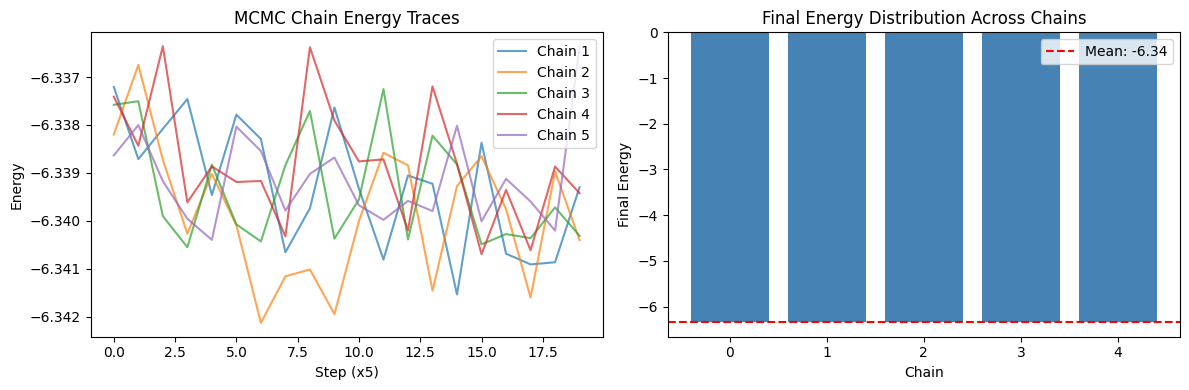


📊 Chain Convergence Summary:
   Mean final energy: -6.3392
   Std final energy: 0.0015
   Ground truth energy: -6.3316
   Gap (chains - real): -0.0076


In [16]:
# MCMC Chain Diagnostics (fixed for dict batches)

import torch
import numpy as np
import matplotlib.pyplot as plt

print("🔗 MCMC Chain Diagnostics...")

# Get test batch (dict format)
test_batch = next(iter(val_loader))
u_real = test_batch['u_zt'].to(CONFIG["device"])       # [B, Z, T, F]
h_zt = test_batch['h_zt'].to(CONFIG["device"])         # [B, Z, T, D]
zone_mask = test_batch['zone_mask'].to(CONFIG["device"])  # [B, Z]

B, Z, T, F = u_real.shape
print(f"📦 Batch: {B} samples, {Z} zones, {T} timesteps, {F} features")

# Run multiple chains
n_chains = 5
n_steps = 100
chain_energies = []

# Model must be in train mode for GRU backward
model.train()

for chain_idx in range(n_chains):
    # Random initialization in logit space
    z = torch.randn(B, Z, T, F, device=CONFIG["device"]) * 0.1 + sampler.prior_logit
    z = z.requires_grad_(True)

    chain_energy = []

    for step in range(n_steps):
        # Relaxation
        u = torch.sigmoid(z)

        # Apply zone mask
        mask = zone_mask.view(B, Z, 1, 1).float()
        u_masked = u * mask

        # Compute energy
        energy = model(u_masked, h_zt, zone_mask).sum()

        # Gradient
        grad_z = torch.autograd.grad(energy, z)[0]

        # Normalize gradient
        g_std = grad_z.std()
        if g_std > 1e-9:
            grad_z = grad_z / g_std

        # Prior drift
        prior_drift = 3.0 * (z.detach() - sampler.prior_logit)

        # Langevin update
        step_size = 0.02
        noise = torch.randn_like(z) * 0.1

        z = z - step_size * grad_z - step_size * prior_drift + noise
        z = z * mask  # Zero out padded zones
        z = z.detach().requires_grad_(True)

        if step % 5 == 0:
            with torch.no_grad():
                e = model(torch.sigmoid(z) * mask, h_zt, zone_mask).mean().item()
            chain_energy.append(e)

    chain_energies.append(chain_energy)
    print(f"  Chain {chain_idx+1}: Final E = {chain_energy[-1]:.4f}")

# Plot chain convergence
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, energies in enumerate(chain_energies):
    axes[0].plot(energies, label=f'Chain {i+1}', alpha=0.7)
axes[0].set_xlabel('Step (x5)')
axes[0].set_ylabel('Energy')
axes[0].set_title('MCMC Chain Energy Traces')
axes[0].legend()

# Final energy distribution
final_energies = [e[-1] for e in chain_energies]
axes[1].bar(range(n_chains), final_energies, color='steelblue')
axes[1].axhline(y=np.mean(final_energies), color='red', linestyle='--',
                label=f'Mean: {np.mean(final_energies):.2f}')
axes[1].set_xlabel('Chain')
axes[1].set_ylabel('Final Energy')
axes[1].set_title('Final Energy Distribution Across Chains')
axes[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_dir'], 'temporal_mcmc_diagnostics.png'), dpi=150)
plt.show()

# Ground truth energy for comparison
with torch.no_grad():
    E_real = model(u_real, h_zt, zone_mask).mean().item()

print(f"\n📊 Chain Convergence Summary:")
print(f"   Mean final energy: {np.mean(final_energies):.4f}")
print(f"   Std final energy: {np.std(final_energies):.4f}")
print(f"   Ground truth energy: {E_real:.4f}")
print(f"   Gap (chains - real): {np.mean(final_energies) - E_real:.4f}")

In [17]:
# Configuration for multi-candidate evaluation (fixed for dict batches)
K_CANDIDATES = 10  # Number of candidates to generate per scenario
N_SCENARIOS_TO_EVAL = 50  # Number of scenarios to fully evaluate

print("=" * 80)
print("MULTI-CANDIDATE GENERATION & EVALUATION")
print("=" * 80)
print(f"Configuration:")
print(f"  - K candidates per scenario: {K_CANDIDATES}")
print(f"  - Scenarios for full LP evaluation: {N_SCENARIOS_TO_EVAL}")
print(f"  - Langevin sampler steps: {sampler.num_steps}")
print("=" * 80)

# Get validation batch (dict format)
val_batch = next(iter(val_loader))
u_pos = val_batch['u_zt'].to(CONFIG['device'])       # [B, Z, T, F]
h_zt = val_batch['h_zt'].to(CONFIG['device'])        # [B, Z, T, D]
zone_mask = val_batch['zone_mask'].to(CONFIG['device'])  # [B, Z]
scenario_ids = val_batch.get('scenario_ids', [f"scenario_{i:05d}" for i in range(len(u_pos))])

B, Z, T, F = u_pos.shape

# Limit to N_SCENARIOS_TO_EVAL
n_eval = min(N_SCENARIOS_TO_EVAL, B)

print(f"\n✓ Loaded {B} scenarios from validation batch")
print(f"  Shape: [B={B}, Z={Z}, T={T}, F={F}]")
print(f"  Evaluating first {n_eval} scenarios")

# Generate K candidates for each scenario
print(f"\n🎲 Generating {K_CANDIDATES} candidates per scenario...")

model.train()  # Required for cuDNN GRU backward

all_candidates = []  # List of [K, Z, T, F] per scenario
all_energies = []    # List of [K] energies per scenario

for i in range(n_eval):
    # Extract single scenario
    h_i = h_zt[i:i+1]          # [1, Z, T, D]
    mask_i = zone_mask[i:i+1]  # [1, Z]

    candidates_i = []
    energies_i = []

    for k in range(K_CANDIDATES):
        # Sample one candidate
        u_sample = sampler.sample(h_i, mask_i)  # [1, Z, T, F]

        # Compute energy
        with torch.no_grad():
            E = model(u_sample, h_i, mask_i).item()

        candidates_i.append(u_sample[0].cpu())  # [Z, T, F]
        energies_i.append(E)

    # Stack candidates
    candidates_i = torch.stack(candidates_i, dim=0)  # [K, Z, T, F]
    energies_i = torch.tensor(energies_i)            # [K]

    all_candidates.append(candidates_i)
    all_energies.append(energies_i)

    if (i + 1) % 10 == 0:
        print(f"  Generated candidates for {i+1}/{n_eval} scenarios")

print(f"\n✓ Generated {K_CANDIDATES} candidates for {n_eval} scenarios")

# Analyze energy distribution
print(f"\n📊 Energy Distribution Analysis:")
for i in range(min(5, n_eval)):
    E = all_energies[i]
    print(f"  Scenario {i}: E_min={E.min():.4f}, E_mean={E.mean():.4f}, E_max={E.max():.4f}")

# Select best candidate per scenario (lowest energy)
best_candidates = []
best_energies = []

for i in range(n_eval):
    best_idx = all_energies[i].argmin()
    best_candidates.append(all_candidates[i][best_idx])  # [Z, T, F]
    best_energies.append(all_energies[i][best_idx].item())

print(f"\n✓ Selected best candidate per scenario")
print(f"  Mean best energy: {np.mean(best_energies):.4f}")
print(f"  Std best energy: {np.std(best_energies):.4f}")

MULTI-CANDIDATE GENERATION & EVALUATION
Configuration:
  - K candidates per scenario: 10
  - Scenarios for full LP evaluation: 50
  - Langevin sampler steps: 100

✓ Loaded 128 scenarios from validation batch
  Shape: [B=128, Z=109, T=24, F=7]
  Evaluating first 50 scenarios

🎲 Generating 10 candidates per scenario...
  Generated candidates for 10/50 scenarios
  Generated candidates for 20/50 scenarios
  Generated candidates for 30/50 scenarios
  Generated candidates for 40/50 scenarios
  Generated candidates for 50/50 scenarios

✓ Generated 10 candidates for 50 scenarios

📊 Energy Distribution Analysis:
  Scenario 0: E_min=-6.3682, E_mean=-6.3463, E_max=-6.3186
  Scenario 1: E_min=-6.3508, E_mean=-6.3385, E_max=-6.3321
  Scenario 2: E_min=-6.3518, E_mean=-6.3419, E_max=-6.3178
  Scenario 3: E_min=-6.3587, E_mean=-6.3417, E_max=-6.3169
  Scenario 4: E_min=-6.3560, E_mean=-6.3414, E_max=-6.3336

✓ Selected best candidate per scenario
  Mean best energy: -6.3590
  Std best energy: 0.0075


In [2]:
# ==============================================================================
# SAVE GENERATED CANDIDATES FOR LOCAL EXECUTION
# ==============================================================================
# This cell saves the sampler output so you can run the decoder locally
# without re-running the EBM sampling (which requires GPU + high RAM).
# ==============================================================================

import torch
import os
from datetime import datetime

# Output path for saved candidates
CANDIDATES_SAVE_PATH = os.path.join(CONFIG['output_dir'], 'sampled_candidates.pt')

# Prepare data to save
save_data = {
    # Main outputs
    'best_candidates': [c.cpu() for c in best_candidates],  # List of [Z, T, F] tensors
    'best_energies': best_energies,                          # List of floats
    'scenario_ids': scenario_ids[:len(best_candidates)],     # Corresponding scenario IDs
    
    # All candidates if available (for analysis)
    'all_candidates': [[c.cpu() for c in cands] for cands in all_candidates] if 'all_candidates' in dir() else None,
    'all_energies': [e.cpu() if isinstance(e, torch.Tensor) else e for e in all_energies] if 'all_energies' in dir() else None,
    
    # Metadata
    'n_scenarios': len(best_candidates),
    'k_candidates': K_CANDIDATES if 'K_CANDIDATES' in dir() else None,
    'timestamp': datetime.now().isoformat(),
    
    # Config for reproducibility
    'config': {
        'n_features_per_zt': N_FEATURES_PER_ZT,
        'n_timesteps': N_TIMESTEPS,
        'embed_dim': CONFIG['embed_dim'],
        'scenarios_dir': CONFIG['scenarios_dir'],
    }
}

# Save
print(f"💾 Saving sampled candidates to: {CANDIDATES_SAVE_PATH}")
torch.save(save_data, CANDIDATES_SAVE_PATH)

# Verify
file_size_mb = os.path.getsize(CANDIDATES_SAVE_PATH) / 1e6
print(f"✅ Saved successfully!")
print(f"   File size: {file_size_mb:.1f} MB")
print(f"   Scenarios: {len(best_candidates)}")
print(f"   Sample shape: {best_candidates[0].shape if best_candidates else 'N/A'}")
print(f"\n📋 To load locally, use the next cell or copy the file to your local machine.")

NameError: name 'CONFIG' is not defined

In [1]:
# ==============================================================================
# LOAD SAVED CANDIDATES FOR LOCAL EXECUTION (SKIP SAMPLING)
# ==============================================================================
# Use this cell to load pre-generated candidates when running locally.
# This allows you to skip the EBM sampling (cells 1-27) and go directly
# to the decoder and LP worker sections.
#
# Requirements for local execution:
#   1. Copy 'sampled_candidates.pt' from Drive to your local outputs folder
#   2. Have the scenarios JSON files available locally
#   3. Run this cell instead of the sampling cells
# ==============================================================================

import torch
import os
import sys

# === CONFIGURATION FOR LOCAL EXECUTION ===
# Adjust these paths for your local machine
LOCAL_MODE = True  # Set to True when running locally

if LOCAL_MODE:
    # Local paths - adjust as needed
    REPO_PATH = r'C:\Users\Dell\projects\multilayer_milp_gnn\benchmark'  # Windows example
    # REPO_PATH = '/home/user/benchmark'  # Linux example
    
    CANDIDATES_FILE = os.path.join(REPO_PATH, 'outputs', 'ebm_models', 'sampled_candidates.pt')
    SCENARIOS_DIR = os.path.join(REPO_PATH, 'outputs', 'scenarios_v1_filtered')
    
    # Add repo to path if not already
    if REPO_PATH not in sys.path:
        sys.path.insert(0, REPO_PATH)
    
    # Load saved candidates
    print(f"📂 Loading saved candidates from: {CANDIDATES_FILE}")
    
    if not os.path.exists(CANDIDATES_FILE):
        raise FileNotFoundError(
            f"Candidates file not found: {CANDIDATES_FILE}\n"
            f"Please copy 'sampled_candidates.pt' from Google Drive to this location."
        )
    
    saved_data = torch.load(CANDIDATES_FILE, map_location='cpu', weights_only=False)
    
    # Restore variables
    best_candidates = saved_data['best_candidates']
    best_energies = saved_data['best_energies']
    scenario_ids = saved_data['scenario_ids']
    
    # Restore all_candidates if available
    if saved_data.get('all_candidates') is not None:
        all_candidates = saved_data['all_candidates']
        all_energies = saved_data['all_energies']
    
    # Restore config
    saved_config = saved_data['config']
    N_FEATURES_PER_ZT = saved_config['n_features_per_zt']
    N_TIMESTEPS = saved_config['n_timesteps']
    
    # Create CONFIG dict for compatibility
    CONFIG = {
        'scenarios_dir': SCENARIOS_DIR,
        'output_dir': os.path.join(REPO_PATH, 'outputs', 'ebm_models'),
        'embed_dim': saved_config['embed_dim'],
        'n_features_per_zt': N_FEATURES_PER_ZT,
        'n_timesteps': N_TIMESTEPS,
    }
    
    print(f"✅ Loaded {len(best_candidates)} candidates")
    print(f"   Timestamp: {saved_data.get('timestamp', 'N/A')}")
    print(f"   Sample shape: {best_candidates[0].shape}")
    print(f"   K candidates: {saved_data.get('k_candidates', 'N/A')}")
    print(f"\n🚀 Ready to run decoder and LP worker locally!")
    print(f"   Skip to '## 10. Hierarchical Feasibility Decoder' section.")
else:
    print("ℹ️ LOCAL_MODE is False - using candidates from sampling.")
    print("   Set LOCAL_MODE = True to load from file instead.")

📂 Loading saved candidates from: C:\Users\Dell\projects\multilayer_milp_gnn\benchmark\outputs\ebm_models\sampled_candidates.pt
✅ Loaded 50 candidates
   Timestamp: 2026-01-08T09:11:52.329473
   Sample shape: torch.Size([109, 24, 7])
   K candidates: 10

🚀 Ready to run decoder and LP worker locally!
   Skip to '## 10. Hierarchical Feasibility Decoder' section.


## 10. Hierarchical Feasibility Decoder

This section implements a **hierarchical feasibility decoder** that transforms relaxed EBM samples into physically feasible dispatch plans using a two-pass architecture:

1. **Top-Down Pass (Budget Allocation)**: National → Regions → Zones → Assets
2. **Bottom-Up Pass (Reconciliation)**: Assets → Zones → Regions → National

The decoder uses the relaxed `u_relax` values as **priorities** (not direct decisions) to guide allocation.

In [2]:
# ==============================================================================
# SCENARIO PHYSICS & FEASIBLE PLAN - Simplified for LP Plug
# ==============================================================================

from dataclasses import dataclass
from typing import Optional, List, Dict

@dataclass
class ScenarioPhysics:
    """Physics and constraints for a scenario - simplified."""

    # Dimensions
    n_zones: int
    n_timesteps: int
    n_regions: int = 1
    dt_hours: float = 1.0

    # Topology
    zone_names: Optional[List[str]] = None
    zone_to_region: Optional[Dict[str, int]] = None

    # Time series [Z, T]
    demand: Optional[torch.Tensor] = None
    solar_available: Optional[torch.Tensor] = None
    wind_available: Optional[torch.Tensor] = None
    hydro_ror: Optional[torch.Tensor] = None

    # Storage [Z]
    battery_power_mw: Optional[torch.Tensor] = None
    battery_capacity_mwh: Optional[torch.Tensor] = None
    battery_initial_soc: Optional[torch.Tensor] = None
    battery_efficiency: float = 0.90

    pumped_power_mw: Optional[torch.Tensor] = None
    pumped_capacity_mwh: Optional[torch.Tensor] = None
    pumped_initial_soc: Optional[torch.Tensor] = None
    pumped_efficiency: float = 0.80

    # Thermal [Z]
    thermal_capacity_mw: Optional[torch.Tensor] = None
    thermal_min_mw: Optional[torch.Tensor] = None

    # Nuclear [Z]
    nuclear_capacity_mw: Optional[torch.Tensor] = None

    # Hydro reservoir [Z]
    hydro_capacity_mw: Optional[torch.Tensor] = None
    hydro_capacity_mwh: Optional[torch.Tensor] = None
    hydro_initial: Optional[torch.Tensor] = None
    hydro_inflow: Optional[torch.Tensor] = None

    # DR [Z]
    dr_capacity_mw: Optional[torch.Tensor] = None
    dr_max_duration_hours: float = 4.0

    # Import/export
    import_capacity_mw: float = 0.0

    # Raw data
    scenario_data: Optional[dict] = None


@dataclass
class FeasiblePlan:
    """
    Simplified feasible dispatch plan - key decision variables only.
    LP worker will compute remaining MILP variables.
    """

    # Binary/relaxed decisions [Z, T]
    thermal_on: torch.Tensor          # Thermal commitment
    nuclear_on: torch.Tensor          # Nuclear active (always 1 if capacity > 0)
    battery_charging: torch.Tensor    # Battery charging flag
    battery_discharging: torch.Tensor # Battery discharging flag
    pumped_charging: torch.Tensor     # Pumped charging flag
    pumped_discharging: torch.Tensor  # Pumped discharging flag
    dr_active: torch.Tensor           # DR active flag

    # Continuous dispatch [Z, T]
    thermal_dispatch: torch.Tensor    # Thermal power output
    nuclear_dispatch: torch.Tensor    # Nuclear power output
    battery_charge: torch.Tensor      # Battery charge power
    battery_discharge: torch.Tensor   # Battery discharge power
    pumped_charge: torch.Tensor       # Pumped charge power
    pumped_discharge: torch.Tensor    # Pumped discharge power
    demand_response: torch.Tensor     # DR curtailment

    # VRE dispatch [Z, T]
    solar_dispatch: torch.Tensor      # Solar dispatched
    wind_dispatch: torch.Tensor       # Wind dispatched
    hydro_dispatch: torch.Tensor      # Hydro reservoir release

    # Balancing [Z, T]
    unserved_energy: torch.Tensor     # Unserved load
    curtailment: torch.Tensor         # Total VRE curtailment
    net_import: torch.Tensor          # Net import (+ = import, - = export)

    # Storage state [Z, T+1]
    battery_soc: torch.Tensor
    pumped_level: torch.Tensor

    def to_tensor(self) -> torch.Tensor:
        """Convert to binary tensor [Z, T, F] for EBM comparison."""
        Z, T = self.thermal_dispatch.shape
        # Features: [batt_ch, batt_dis, pump_ch, pump_dis, dr, nuclear, thermal]
        u = torch.zeros(Z, T, 7)
        u[:, :, 0] = self.battery_charging
        u[:, :, 1] = self.battery_discharging
        u[:, :, 2] = self.pumped_charging
        u[:, :, 3] = self.pumped_discharging
        u[:, :, 4] = self.dr_active
        u[:, :, 5] = self.nuclear_on
        u[:, :, 6] = self.thermal_on
        return u


print("ScenarioPhysics & FeasiblePlan defined (simplified for LP plug)")

ScenarioPhysics & FeasiblePlan defined (simplified for LP plug)


In [3]:
# ==============================================================================
# HIERARCHICAL FEASIBILITY DECODER - v4 (COST-AWARE Merit Order)
# ==============================================================================
# Takes Langevin samples and projects them into feasible space.
# LP worker will compute remaining MILP variables afterwards.
#
# KEY CHANGE from v3: Merit order is now COST-AWARE
# - In SURPLUS: prioritize CURTAILMENT (8 EUR/MWh) BEFORE storage cycling
# - In DEFICIT: prioritize cheap sources before expensive thermal
#
# Merit Order for DEFICIT (demand > supply) - sorted by cost:
#   1. VRE (solar + wind) - FREE, must-take
#   2. Hydro RoR - FREE, must-take
#   3. Nuclear must-run (20%) - ~1 EUR/MWh
#   4. Nuclear remaining - ~1 EUR/MWh
#   5. Hydro reservoir - ~2 EUR/MWh
#   6. Storage discharge (if already charged) - 0 marginal cost
#   7. Imports - ~90 EUR/MWh (price_cap * 0.9)
#   8. Demand Response - ~100 EUR/MWh
#   9. Thermal - ~70 EUR/MWh BUT causes cycling costs
#   10. Unserved - 10000 EUR/MWh (VOLL)
#
# Merit Order for SURPLUS (supply > demand) - COST-AWARE:
#   1. CURTAILMENT FIRST (8 EUR/MWh) - CHEAP!
#   2. Reduce thermal if running (saves fuel cost)
#   3. Storage charge (if economical)
#   4. Exports (earn revenue)
#   5. Overgeneration spill (last resort)
# ==============================================================================

class HierarchicalFeasibilityDecoder:
    """
    v4 - COST-AWARE Merit Order Decoder with Nuclear Must-Run at 20%.

    KEY IMPROVEMENT: Prioritizes curtailment over storage cycling in surplus.
    This aligns with MILP behavior where spill costs (8 EUR/MWh) are cheaper
    than storage cycling costs and thermal dispatch.
    """

    FEAT_BATTERY_CHARGE = 0
    FEAT_BATTERY_DISCHARGE = 1
    FEAT_PUMPED_CHARGE = 2
    FEAT_PUMPED_DISCHARGE = 3
    FEAT_DR = 4
    FEAT_NUCLEAR = 5
    FEAT_THERMAL = 6

    def __init__(
        self,
        physics: ScenarioPhysics,
        nuclear_must_run_fraction: float = 0.20,
        verbose: bool = False
    ):
        self.physics = physics
        self.nuclear_must_run_fraction = nuclear_must_run_fraction
        self.verbose = verbose

    def decode(self, u_relax: torch.Tensor) -> FeasiblePlan:
        """
        Project relaxed sample to feasible dispatch.

        Args:
            u_relax: [Z, T, F] relaxed binary decisions from Langevin sampler

        Returns:
            FeasiblePlan with feasible dispatch decisions
        """
        Z, T, F = u_relax.shape
        p = self.physics
        dt = p.dt_hours

        # Get capacities (safe defaults)
        batt_power = p.battery_power_mw if p.battery_power_mw is not None else torch.zeros(Z)
        batt_cap = p.battery_capacity_mwh if p.battery_capacity_mwh is not None else torch.zeros(Z)
        pump_power = p.pumped_power_mw if p.pumped_power_mw is not None else torch.zeros(Z)
        pump_cap = p.pumped_capacity_mwh if p.pumped_capacity_mwh is not None else torch.zeros(Z)
        dr_cap = p.dr_capacity_mw if p.dr_capacity_mw is not None else torch.zeros(Z)
        therm_cap = p.thermal_capacity_mw if p.thermal_capacity_mw is not None else torch.zeros(Z)
        therm_min = p.thermal_min_mw if p.thermal_min_mw is not None else therm_cap * 0.3
        nuc_cap = p.nuclear_capacity_mw if p.nuclear_capacity_mw is not None else torch.zeros(Z)
        hydro_cap_mw = p.hydro_capacity_mw if p.hydro_capacity_mw is not None else torch.zeros(Z)
        hydro_cap_mwh = p.hydro_capacity_mwh if p.hydro_capacity_mwh is not None else torch.zeros(Z)
        import_cap = p.import_capacity_mw

        # Nuclear must-run = 20% of capacity
        nuc_must_run = nuc_cap * self.nuclear_must_run_fraction

        # Initialize outputs
        thermal_on = torch.zeros(Z, T)
        nuclear_on = torch.zeros(Z, T)
        battery_charging = torch.zeros(Z, T)
        battery_discharging = torch.zeros(Z, T)
        pumped_charging = torch.zeros(Z, T)
        pumped_discharging = torch.zeros(Z, T)
        dr_active = torch.zeros(Z, T)

        thermal_dispatch = torch.zeros(Z, T)
        nuclear_dispatch = torch.zeros(Z, T)
        battery_charge = torch.zeros(Z, T)
        battery_discharge = torch.zeros(Z, T)
        pumped_charge = torch.zeros(Z, T)
        pumped_discharge = torch.zeros(Z, T)
        demand_response = torch.zeros(Z, T)

        solar_dispatch = torch.zeros(Z, T)
        wind_dispatch = torch.zeros(Z, T)
        hydro_dispatch = torch.zeros(Z, T)

        unserved_energy = torch.zeros(Z, T)
        curtailment = torch.zeros(Z, T)
        net_import = torch.zeros(Z, T)

        battery_soc = torch.zeros(Z, T + 1)
        pumped_level = torch.zeros(Z, T + 1)

        # Initialize storage states
        b_soc = torch.zeros(Z)
        p_level = torch.zeros(Z)
        h_level = torch.zeros(Z)
        dr_used_hours = torch.zeros(Z)

        if p.battery_initial_soc is not None and batt_cap is not None:
            b_soc = (p.battery_initial_soc * batt_cap).clone()
        if p.pumped_initial_soc is not None and pump_cap is not None:
            p_level = (p.pumped_initial_soc * pump_cap).clone()
        if p.hydro_initial is not None:
            h_level = p.hydro_initial.clone()

        battery_soc[:, 0] = b_soc.clone()
        pumped_level[:, 0] = p_level.clone()

        eta_batt = p.battery_efficiency
        eta_pump = p.pumped_efficiency

        for t in range(T):
            demand_t = p.demand[:, t].clone() if p.demand is not None else torch.zeros(Z)

            # Get available resources
            solar_avail = p.solar_available[:, t].clone() if p.solar_available is not None else torch.zeros(Z)
            wind_avail = p.wind_available[:, t].clone() if p.wind_available is not None else torch.zeros(Z)
            ror_t = p.hydro_ror[:, t].clone() if p.hydro_ror is not None else torch.zeros(Z)
            hydro_inflow_t = p.hydro_inflow[:, t] if p.hydro_inflow is not None else torch.zeros(Z)

            # Update hydro reservoir with inflow
            h_level = h_level + hydro_inflow_t * dt
            h_level = torch.clamp(h_level, max=hydro_cap_mwh)

            # Track residual demand per zone
            residual = demand_t.clone()

            # ==================================================================
            # PHASE 1: DISPATCH MUST-RUN AND FREE RESOURCES
            # ==================================================================

            # 1a. Nuclear must-run (20% of capacity) - CHEAPEST at ~1 EUR/MWh
            nuc_dispatch_t = nuc_must_run.clone()
            nuclear_dispatch[:, t] = nuc_dispatch_t
            nuclear_on[:, t] = (nuc_cap > 0).float()
            residual = residual - nuc_dispatch_t

            # 1b. VRE - dispatch all available (FREE, must-take)
            solar_dispatch[:, t] = solar_avail
            wind_dispatch[:, t] = wind_avail
            residual = residual - solar_avail - wind_avail

            # 1c. Hydro RoR (must-take, FREE)
            residual = residual - ror_t

            # ==================================================================
            # PHASE 2: HANDLE DEFICIT (residual > 0) - COST-AWARE Merit Order
            # ==================================================================
            for z in range(Z):
                if residual[z] <= 0:
                    continue

                # 2a. Nuclear remaining (above must-run) - ~1 EUR/MWh
                nuc_headroom = nuc_cap[z] - nuc_dispatch_t[z]
                if nuc_headroom > 0:
                    nuc_add = min(nuc_headroom.item(), residual[z].item())
                    nuclear_dispatch[z, t] += nuc_add
                    residual[z] -= nuc_add

                if residual[z] <= 0:
                    continue

                # 2b. Hydro reservoir release - ~2 EUR/MWh
                if hydro_cap_mw[z] > 0 and h_level[z] > 0:
                    max_release = min(hydro_cap_mw[z].item(), h_level[z].item() / dt)
                    release = min(max_release, residual[z].item())
                    hydro_dispatch[z, t] = release
                    h_level[z] -= release * dt
                    residual[z] -= release

                if residual[z] <= 0:
                    continue

                # 2c. Pumped storage discharge (0 marginal cost if already charged)
                if pump_power[z] > 0 and p_level[z] > 0:
                    max_dis = min(pump_power[z].item(), p_level[z].item() / eta_pump / dt)
                    dis = min(max(max_dis, 0), residual[z].item())
                    pumped_discharge[z, t] = dis
                    pumped_discharging[z, t] = 1.0 if dis > 0 else 0.0
                    p_level[z] -= dis * dt * eta_pump
                    residual[z] -= dis

                if residual[z] <= 0:
                    continue

                # 2d. Battery discharge (0 marginal cost if already charged)
                if batt_power[z] > 0 and b_soc[z] > 0:
                    max_dis = min(batt_power[z].item(), b_soc[z].item() / eta_batt / dt)
                    dis = min(max(max_dis, 0), residual[z].item())
                    battery_discharge[z, t] = dis
                    battery_discharging[z, t] = 1.0 if dis > 0 else 0.0
                    b_soc[z] -= dis * dt * eta_batt
                    residual[z] -= dis

                if residual[z] <= 0:
                    continue

                # 2e. Thermal dispatch - ~70 EUR/MWh (MOVED UP - often cheaper than DR)
                if therm_cap[z] > 0:
                    dispatch = min(therm_cap[z].item(), residual[z].item())
                    if dispatch > 0 and dispatch < therm_min[z].item():
                        dispatch = min(therm_min[z].item(), therm_cap[z].item())
                    thermal_dispatch[z, t] = dispatch
                    thermal_on[z, t] = 1.0 if dispatch > 0 else 0.0
                    residual[z] -= dispatch

                if residual[z] <= 0:
                    continue

                # 2f. Imports - ~90 EUR/MWh
                if import_cap > 0:
                    imp = min(import_cap, residual[z].item())
                    net_import[z, t] = imp
                    residual[z] -= imp

                if residual[z] <= 0:
                    continue

                # 2g. Demand Response - ~100 EUR/MWh
                if dr_cap[z] > 0 and dr_used_hours[z] < p.dr_max_duration_hours:
                    dr = min(dr_cap[z].item(), residual[z].item())
                    demand_response[z, t] = dr
                    dr_active[z, t] = 1.0 if dr > 0 else 0.0
                    dr_used_hours[z] += dt
                    residual[z] -= dr

                if residual[z] <= 0:
                    continue

                # 2h. Unserved (last resort) - 10000 EUR/MWh
                if residual[z] > 1e-6:
                    unserved_energy[z, t] = max(0, residual[z].item())
                    residual[z] = 0

            # ==================================================================
            # PHASE 3: HANDLE SURPLUS (residual < 0) - COST-AWARE Merit Order
            # KEY CHANGE: Curtail FIRST (8 EUR/MWh) before storage cycling!
            # ==================================================================
            surplus = torch.clamp(-residual, min=0)

            for z in range(Z):
                if surplus[z] <= 0:
                    continue

                # 3a. CURTAILMENT FIRST - Wind spill (8 EUR/MWh) - CHEAPEST!
                wind_dispatched = wind_dispatch[z, t].item()
                if wind_dispatched > 0:
                    spill = min(wind_dispatched, surplus[z].item())
                    wind_dispatch[z, t] -= spill
                    curtailment[z, t] += spill
                    surplus[z] -= spill

                if surplus[z] <= 0:
                    continue

                # 3b. CURTAILMENT - Solar spill (8 EUR/MWh) - CHEAPEST!
                solar_dispatched = solar_dispatch[z, t].item()
                if solar_dispatched > 0:
                    spill = min(solar_dispatched, surplus[z].item())
                    solar_dispatch[z, t] -= spill
                    curtailment[z, t] += spill
                    surplus[z] -= spill

                if surplus[z] <= 0:
                    continue

                # 3c. Reduce thermal if running (saves fuel cost ~70 EUR/MWh)
                therm_running = thermal_dispatch[z, t].item()
                if therm_running > 0:
                    reduce = min(therm_running - therm_min[z].item(), surplus[z].item())
                    if reduce > 0:
                        thermal_dispatch[z, t] -= reduce
                        if thermal_dispatch[z, t] < 1e-6:
                            thermal_on[z, t] = 0.0
                        surplus[z] -= reduce

                if surplus[z] <= 0:
                    continue

                # 3d. Exports (earn revenue ~18 EUR/MWh)
                if import_cap > 0:
                    exp = min(import_cap, surplus[z].item())
                    net_import[z, t] -= exp
                    surplus[z] -= exp

                if surplus[z] <= 0:
                    continue

                # 3e. Pumped storage charge (only if very cheap surplus remains)
                if pump_power[z] > 0 and pump_cap[z] > 0:
                    headroom = pump_cap[z].item() - p_level[z].item()
                    if headroom > 0:
                        max_ch = min(pump_power[z].item(), headroom / eta_pump / dt)
                        ch = min(max(max_ch, 0), surplus[z].item())
                        pumped_charge[z, t] = ch
                        pumped_charging[z, t] = 1.0 if ch > 0 else 0.0
                        p_level[z] += ch * dt * eta_pump
                        surplus[z] -= ch

                if surplus[z] <= 0:
                    continue

                # 3f. Battery charge (only if very cheap surplus remains)
                if batt_power[z] > 0 and batt_cap[z] > 0:
                    headroom = batt_cap[z].item() - b_soc[z].item()
                    if headroom > 0:
                        max_ch = min(batt_power[z].item(), headroom / eta_batt / dt)
                        ch = min(max(max_ch, 0), surplus[z].item())
                        battery_charge[z, t] = ch
                        battery_charging[z, t] = 1.0 if ch > 0 else 0.0
                        b_soc[z] += ch * dt * eta_batt
                        surplus[z] -= ch

                if surplus[z] <= 0:
                    continue

                # 3g. Overgeneration spill (absorbed in curtailment) - last resort
                if surplus[z] > 1e-6:
                    curtailment[z, t] += surplus[z].item()
                    surplus[z] = 0

            # Update storage states
            battery_soc[:, t + 1] = b_soc.clone()
            pumped_level[:, t + 1] = p_level.clone()

        return FeasiblePlan(
            thermal_on=thermal_on,
            nuclear_on=nuclear_on,
            battery_charging=battery_charging,
            battery_discharging=battery_discharging,
            pumped_charging=pumped_charging,
            pumped_discharging=pumped_discharging,
            dr_active=dr_active,
            thermal_dispatch=thermal_dispatch,
            nuclear_dispatch=nuclear_dispatch,
            battery_charge=battery_charge,
            battery_discharge=battery_discharge,
            pumped_charge=pumped_charge,
            pumped_discharge=pumped_discharge,
            demand_response=demand_response,
            solar_dispatch=solar_dispatch,
            wind_dispatch=wind_dispatch,
            hydro_dispatch=hydro_dispatch,
            unserved_energy=unserved_energy,
            curtailment=curtailment,
            net_import=net_import,
            battery_soc=battery_soc,
            pumped_level=pumped_level,
        )


print("HierarchicalFeasibilityDecoder v4 defined (COST-AWARE)")
print("  - Nuclear must-run: 20% of capacity")
print("  - Merit order DEFICIT: VRE > RoR > Nuc > Hydro > Storage > Thermal > Import > DR > Unserved")
print("  - Merit order SURPLUS: CURTAIL FIRST > Reduce Thermal > Export > Storage charge")
print("  - Key change: Curtailment (8 EUR/MWh) now BEFORE storage cycling")

HierarchicalFeasibilityDecoder v4 defined (COST-AWARE)
  - Nuclear must-run: 20% of capacity
  - Merit order DEFICIT: VRE > RoR > Nuc > Hydro > Storage > Thermal > Import > DR > Unserved
  - Merit order SURPLUS: CURTAIL FIRST > Reduce Thermal > Export > Storage charge
  - Key change: Curtailment (8 EUR/MWh) now BEFORE storage cycling


In [4]:
# ==============================================================================
# LOAD PHYSICS FROM SCENARIO JSON (Using same logic as MILP scenario_loader)
# ==============================================================================
# Generates time series from capacities and profiles, NOT from dispatch results.
# ==============================================================================

import sys
import os

# Add src to path for imports
src_path = os.path.join(os.path.dirname(CONFIG.get('scenarios_dir', '')), '..', 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)

try:
    from milp.scenario_loader import load_scenario_data
    USE_MILP_LOADER = True
    print("Using MILP scenario_loader for time series generation")
except ImportError:
    USE_MILP_LOADER = False
    print("MILP scenario_loader not available, using simplified loader")


def load_physics_from_scenario_json(
    scenario_id: str,
    scenarios_dir: str,
    n_timesteps: int = 24,
) -> ScenarioPhysics:
    """
    Load physics from scenario JSON using MILP scenario_loader.
    Time series (demand, solar, wind) generated from profiles, not dispatch.
    """
    json_path = os.path.join(scenarios_dir, f'{scenario_id}.json')

    if USE_MILP_LOADER:
        # Use the same loader as MILP for consistency
        from pathlib import Path
        data = load_scenario_data(Path(json_path))

        zones = data.zones
        Z = len(zones)
        T = len(data.periods)

        # Build tensors from ScenarioData
        demand = torch.zeros(Z, T)
        solar_available = torch.zeros(Z, T)
        wind_available = torch.zeros(Z, T)
        hydro_ror = torch.zeros(Z, T)
        hydro_inflow = torch.zeros(Z, T)

        for z_idx, zone in enumerate(zones):
            for t in range(T):
                demand[z_idx, t] = data.demand.get((zone, t), 0.0)
                solar_available[z_idx, t] = data.solar_available.get((zone, t), 0.0)
                wind_available[z_idx, t] = data.wind_available.get((zone, t), 0.0)
                hydro_ror[z_idx, t] = data.hydro_ror_generation.get((zone, t), 0.0)
                hydro_inflow[z_idx, t] = data.hydro_inflow_power.get((zone, t), 0.0)

        # Capacities
        thermal_capacity = torch.tensor([data.thermal_capacity.get(z, 0.0) for z in zones], dtype=torch.float32)
        thermal_min = torch.tensor([data.thermal_min_power.get(z, 0.0) for z in zones], dtype=torch.float32)
        nuclear_capacity = torch.tensor([data.nuclear_capacity.get(z, 0.0) for z in zones], dtype=torch.float32)
        battery_power = torch.tensor([data.battery_power.get(z, 0.0) for z in zones], dtype=torch.float32)
        battery_capacity = torch.tensor([data.battery_energy.get(z, 0.0) for z in zones], dtype=torch.float32)
        battery_initial_soc = torch.tensor([data.battery_initial.get(z, 0.0) / max(data.battery_energy.get(z, 1.0), 1e-6) for z in zones], dtype=torch.float32)
        pumped_power = torch.tensor([data.pumped_power.get(z, 0.0) for z in zones], dtype=torch.float32)
        pumped_capacity = torch.tensor([data.pumped_energy.get(z, 0.0) for z in zones], dtype=torch.float32)
        pumped_initial_soc = torch.tensor([data.pumped_initial.get(z, 0.0) / max(data.pumped_energy.get(z, 1.0), 1e-6) for z in zones], dtype=torch.float32)
        hydro_capacity_mw = torch.tensor([data.hydro_res_capacity.get(z, 0.0) for z in zones], dtype=torch.float32)
        hydro_capacity_mwh = torch.tensor([data.hydro_res_energy.get(z, 0.0) for z in zones], dtype=torch.float32)
        hydro_initial = torch.tensor([data.hydro_initial.get(z, 0.0) for z in zones], dtype=torch.float32)

        # DR capacity from dr_limit (use max over time)
        dr_capacity = torch.zeros(Z)
        for z_idx, zone in enumerate(zones):
            max_dr = max(data.dr_limit.get((zone, t), 0.0) for t in range(T))
            dr_capacity[z_idx] = max_dr

        # Region mapping
        zone_to_region = {z: data.region_of_zone.get(z, 'R1') for z in zones}
        n_regions = len(set(zone_to_region.values()))

        return ScenarioPhysics(
            n_zones=Z,
            n_timesteps=T,
            n_regions=n_regions,
            dt_hours=data.dt_hours,
            zone_names=zones,
            zone_to_region=zone_to_region,
            demand=demand,
            solar_available=solar_available,
            wind_available=wind_available,
            hydro_ror=hydro_ror,
            battery_power_mw=battery_power,
            battery_capacity_mwh=battery_capacity,
            battery_initial_soc=battery_initial_soc,
            battery_efficiency=data.battery_eta_charge,
            pumped_power_mw=pumped_power,
            pumped_capacity_mwh=pumped_capacity,
            pumped_initial_soc=pumped_initial_soc,
            pumped_efficiency=data.pumped_eta_charge,
            thermal_capacity_mw=thermal_capacity,
            thermal_min_mw=thermal_min,
            nuclear_capacity_mw=nuclear_capacity,
            hydro_capacity_mw=hydro_capacity_mw,
            hydro_capacity_mwh=hydro_capacity_mwh,
            hydro_initial=hydro_initial,
            hydro_inflow=hydro_inflow,
            dr_capacity_mw=dr_capacity,
            dr_max_duration_hours=4.0,
            import_capacity_mw=data.import_capacity,
            scenario_data=None,
        )

    else:
        # Fallback: simplified loader (capacities only, no profiles)
        with open(json_path, 'r') as f:
            scenario = json.load(f)

        graph = scenario.get('graph', {})
        assets = scenario.get('assets', {})
        tech = scenario.get('tech', {})

        zones_per_region = graph.get('zones_per_region', [1])
        Z = sum(zones_per_region)
        T = n_timesteps
        n_regions = len(zones_per_region)

        # Build zone names
        zone_names = []
        zone_to_region = {}
        for r_idx, n_z in enumerate(zones_per_region):
            for z in range(n_z):
                zone_name = f"R{r_idx+1}Z{z+1}"
                zone_names.append(zone_name)
                zone_to_region[zone_name] = f"R{r_idx+1}"

        # Capacities from assets (units * unit_capacity)
        SOLAR_UNIT_MW = 45.0
        WIND_UNIT_MW = 80.0
        THERMAL_UNIT_MW = 120.0
        NUCLEAR_UNIT_MW = 900.0
        BATTERY_UNIT_MW = 45.0
        HYDRO_ROR_UNIT_MW = 25.0

        solar_per_zone = assets.get('solar_per_zone', [0] * Z)
        wind_per_zone = assets.get('wind_per_zone', [0] * Z)
        thermal_per_zone = assets.get('thermal_per_zone', [0] * Z)
        battery_per_zone = assets.get('battery_per_zone', [0] * Z)
        dr_per_zone = assets.get('dr_per_zone', [0] * Z)
        ror_per_zone = assets.get('hydro_ror_per_zone', [0] * Z)

        # Distribute regional assets to first zone of each region
        nuclear_per_region = assets.get('nuclear_per_region', [0] * n_regions)
        nuclear_capacity = torch.zeros(Z)
        zone_idx = 0
        for r_idx, n_z in enumerate(zones_per_region):
            if r_idx < len(nuclear_per_region):
                nuclear_capacity[zone_idx] = nuclear_per_region[r_idx] * NUCLEAR_UNIT_MW
            zone_idx += n_z

        # Simple time series (flat capacity factors)
        # Solar: morning ramp up, afternoon peak, evening ramp down
        solar_cf = torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.3, 0.5, 0.7, 0.85, 0.95, 1.0,
                                 1.0, 0.95, 0.85, 0.7, 0.5, 0.3, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0])[:T]
        # Wind: variable
        wind_cf = torch.tensor([0.4, 0.45, 0.5, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.35, 0.4, 0.45,
                                0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45])[:T]
        # Demand: morning and evening peaks
        demand_cf = torch.tensor([0.6, 0.55, 0.5, 0.5, 0.55, 0.65, 0.8, 0.9, 0.95, 1.0, 0.95, 0.9,
                                  0.85, 0.85, 0.85, 0.9, 0.95, 1.0, 0.95, 0.9, 0.8, 0.75, 0.7, 0.65])[:T]

        demand = torch.zeros(Z, T)
        solar_available = torch.zeros(Z, T)
        wind_available = torch.zeros(Z, T)
        hydro_ror = torch.zeros(Z, T)

        base_peak_demand = 180.0 * scenario.get('exogenous', {}).get('demand_scale_factor', 1.0)

        for z_idx in range(Z):
            peak = base_peak_demand * (1.0 + 0.1 * (z_idx % 3))
            demand[z_idx] = peak * demand_cf

            solar_cap = (solar_per_zone[z_idx] if z_idx < len(solar_per_zone) else 0) * SOLAR_UNIT_MW
            solar_available[z_idx] = solar_cap * solar_cf

            wind_cap = (wind_per_zone[z_idx] if z_idx < len(wind_per_zone) else 0) * WIND_UNIT_MW
            wind_available[z_idx] = wind_cap * wind_cf

            ror_units = ror_per_zone[z_idx] if z_idx < len(ror_per_zone) else 0
            hydro_ror[z_idx] = ror_units * HYDRO_ROR_UNIT_MW * 0.6  # 60% avg CF

        thermal_capacity = torch.tensor([(thermal_per_zone[i] if i < len(thermal_per_zone) else 0) * THERMAL_UNIT_MW for i in range(Z)], dtype=torch.float32)
        battery_power = torch.tensor([(battery_per_zone[i] if i < len(battery_per_zone) else 0) * BATTERY_UNIT_MW for i in range(Z)], dtype=torch.float32)
        battery_capacity = battery_power * tech.get('battery_e_to_p_hours', 4.0)
        dr_capacity = torch.tensor([(dr_per_zone[i] if i < len(dr_per_zone) else 0) * 10.0 for i in range(Z)], dtype=torch.float32)

        return ScenarioPhysics(
            n_zones=Z,
            n_timesteps=T,
            n_regions=n_regions,
            dt_hours=1.0,
            zone_names=zone_names,
            zone_to_region=zone_to_region,
            demand=demand,
            solar_available=solar_available,
            wind_available=wind_available,
            hydro_ror=hydro_ror,
            battery_power_mw=battery_power,
            battery_capacity_mwh=battery_capacity,
            battery_initial_soc=torch.ones(Z) * 0.5,
            battery_efficiency=0.9,
            pumped_power_mw=torch.zeros(Z),
            pumped_capacity_mwh=torch.zeros(Z),
            pumped_initial_soc=torch.ones(Z) * 0.5,
            pumped_efficiency=0.8,
            thermal_capacity_mw=thermal_capacity,
            thermal_min_mw=thermal_capacity * 0.3,
            nuclear_capacity_mw=nuclear_capacity,
            hydro_capacity_mw=torch.zeros(Z),
            hydro_capacity_mwh=torch.zeros(Z),
            hydro_initial=torch.zeros(Z),
            hydro_inflow=torch.zeros(Z, T),
            dr_capacity_mw=dr_capacity,
            dr_max_duration_hours=4.0,
            import_capacity_mw=0.0,
            scenario_data=scenario,
        )


print("load_physics_from_scenario_json defined (uses MILP scenario_loader for profiles)")

Using MILP scenario_loader for time series generation
load_physics_from_scenario_json defined (uses MILP scenario_loader for profiles)


In [5]:
# ==============================================================================
# APPLY DECODER TO SAMPLED CANDIDATES (v3 - simplified)
# ==============================================================================

print("=" * 80)
print("APPLYING HIERARCHICAL FEASIBILITY DECODER TO SAMPLED CANDIDATES")
print("=" * 80)

SCENARIOS_JSON_DIR = CONFIG.get('scenarios_dir', 'outputs/scenarios_v1_filtered')
print(f"Loading physics from: {SCENARIOS_JSON_DIR}")

n_to_decode = min(50, len(best_candidates))

decoded_plans = []
decoded_tensors = []
physics_cache = {}

print(f"\nDecoding {n_to_decode} scenarios...")

for i in range(n_to_decode):
    sc_id = scenario_ids[i] if i < len(scenario_ids) else f"scenario_{i+1:05d}"

    u_relax_padded = best_candidates[i]
    Z_padded, T, F = u_relax_padded.shape

    print(f"\n  Scenario {i}: {sc_id} | Padded shape: [Z={Z_padded}, T={T}, F={F}]")

    try:
        # Load physics from JSON
        physics = load_physics_from_scenario_json(
            scenario_id=sc_id,
            scenarios_dir=SCENARIOS_JSON_DIR,
            n_timesteps=T,
        )

        Z_actual = physics.n_zones
        print(f"    Physics: {Z_actual} zones, {physics.n_regions} regions")
        print(f"    Battery: {physics.battery_power_mw.sum():.0f} MW, DR: {physics.dr_capacity_mw.sum():.0f} MW")

        # Check VRE data
        solar_total = physics.solar_available.sum().item() if physics.solar_available is not None else 0
        wind_total = physics.wind_available.sum().item() if physics.wind_available is not None else 0
        print(f"    VRE: Solar={solar_total:.0f} MWh, Wind={wind_total:.0f} MWh")

        # Truncate u_relax to actual zone count
        u_relax = u_relax_padded[:Z_actual, :, :]
        print(f"    Truncated u_relax: [Z={Z_actual}, T={T}, F={F}]")

        physics_cache[sc_id] = physics

        # Decode
        decoder = HierarchicalFeasibilityDecoder(physics, verbose=False)
        plan = decoder.decode(u_relax)
        decoded_plans.append(plan)

        # Convert to tensor
        u_feasible = plan.to_tensor()
        decoded_tensors.append(u_feasible)

        # Stats
        total_unserved = plan.unserved_energy.sum().item()
        total_curtail = plan.curtailment.sum().item()
        total_batt = plan.battery_discharge.sum().item()
        total_dr = plan.demand_response.sum().item()
        total_thermal = plan.thermal_dispatch.sum().item()
        total_nuclear = plan.nuclear_dispatch.sum().item()

        print(f"    Decoded | Nuc: {total_nuclear:.0f} | Thermal: {total_thermal:.0f} | Batt: {total_batt:.0f} | DR: {total_dr:.0f}")
        print(f"    Unserved: {total_unserved:.1f} | Curtailment: {total_curtail:.1f}")

    except FileNotFoundError as e:
        print(f"    JSON file not found: {e}")
        decoded_plans.append(None)
        decoded_tensors.append(None)
    except Exception as e:
        print(f"    Error: {e}")
        import traceback
        traceback.print_exc()
        decoded_plans.append(None)
        decoded_tensors.append(None)

print(f"\nSuccessfully decoded {sum(1 for p in decoded_plans if p is not None)}/{n_to_decode} scenarios")

APPLYING HIERARCHICAL FEASIBILITY DECODER TO SAMPLED CANDIDATES
Loading physics from: C:\Users\Dell\projects\multilayer_milp_gnn\benchmark\outputs\scenarios_v1_filtered

Decoding 50 scenarios...

  Scenario 0: scenario_02608 | Padded shape: [Z=109, T=24, F=7]
    Physics: 15 zones, 2 regions
    Battery: 810 MW, DR: 261 MW
    VRE: Solar=17853 MWh, Wind=43278 MWh
    Truncated u_relax: [Z=15, T=24, F=7]
    Decoded | Nuc: 8640 | Thermal: 6580 | Batt: 681 | DR: 0
    Unserved: 0.0 | Curtailment: 36587.8

  Scenario 1: scenario_01602 | Padded shape: [Z=109, T=24, F=7]
    Physics: 87 zones, 11 regions
    Battery: 3600 MW, DR: 8380 MW
    VRE: Solar=84694 MWh, Wind=170758 MWh
    Truncated u_relax: [Z=87, T=24, F=7]
    Decoded | Nuc: 60671 | Thermal: 54621 | Batt: 5576 | DR: 0
    Unserved: 0.0 | Curtailment: 115626.8

  Scenario 2: scenario_00394 | Padded shape: [Z=109, T=24, F=7]
    Physics: 41 zones, 6 regions
    Battery: 2160 MW, DR: 2171 MW
    VRE: Solar=48325 MWh, Wind=94240 MW

In [6]:
# ==============================================================================
# ANALYZE DECODED RESULTS: Compare relaxed vs feasible
# ==============================================================================

import matplotlib.pyplot as plt

print("=" * 80)
print("ANALYSIS: RELAXED vs FEASIBLE PLANS")
print("=" * 80)

# Compare relaxed and feasible for decoded scenarios
valid_indices = [i for i, p in enumerate(decoded_plans) if p is not None]

if len(valid_indices) > 0:

    # Compute metrics
    hamming_distances = []
    energy_relaxed = []
    energy_feasible = []

    model.eval()

    for i in valid_indices[:50]:  # First 5 valid scenarios
        u_relax = best_candidates[i]
        u_feas = decoded_tensors[i]

        if u_feas is None:
            continue

        # Ensure same shape
        Z_min = min(u_relax.shape[0], u_feas.shape[0])
        u_relax_cmp = u_relax[:Z_min]
        u_feas_cmp = u_feas[:Z_min]

        # Hamming distance (after thresholding relaxed)
        u_relax_bin = (u_relax_cmp > 0.5).float()
        hamming = (u_relax_bin != u_feas_cmp).float().mean().item()
        hamming_distances.append(hamming)

        # Energy comparison (need embeddings)
        sc_id = scenario_ids[i] if i < len(scenario_ids) else f"scenario_{i:05d}"

        # Get embedding for this scenario
        try:
            h_zt_i = zone_embeddings[sc_id][:Z_min].unsqueeze(0).to(CONFIG['device'])  # [1, Z, T, D]
            mask_i = torch.ones(1, Z_min).to(CONFIG['device'])

            u_relax_i = u_relax_cmp.unsqueeze(0).to(CONFIG['device'])  # [1, Z, T, F]
            u_feas_i = u_feas_cmp.unsqueeze(0).to(CONFIG['device'])

            with torch.no_grad():
                E_relax = model(u_relax_i, h_zt_i, mask_i).item()
                E_feas = model(u_feas_i, h_zt_i, mask_i).item()

            energy_relaxed.append(E_relax)
            energy_feasible.append(E_feas)

            print(f"Scenario {i} ({sc_id}):")
            print(f"  Hamming dist (relaxed→feasible): {hamming:.4f}")
            print(f"  Energy relaxed: {E_relax:.4f}")
            print(f"  Energy feasible: {E_feas:.4f}")
            print(f"  Energy gap: {E_feas - E_relax:.4f}")
        except Exception as e:
            print(f"Scenario {i}: Error computing energy - {e}")

    # Summary statistics
    print("\n" + "=" * 60)
    print("SUMMARY STATISTICS")
    print("=" * 60)
    print(f"Mean Hamming distance: {np.mean(hamming_distances):.4f}")
    print(f"Mean energy (relaxed): {np.mean(energy_relaxed):.4f}")
    print(f"Mean energy (feasible): {np.mean(energy_feasible):.4f}")
    print(f"Mean energy gap: {np.mean(np.array(energy_feasible) - np.array(energy_relaxed)):.4f}")

    # Plot comparison
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Hamming distance distribution
    axes[0].bar(range(len(hamming_distances)), hamming_distances, color='steelblue')
    axes[0].set_xlabel('Scenario')
    axes[0].set_ylabel('Hamming Distance')
    axes[0].set_title('Relaxed → Feasible Hamming Distance')
    axes[0].axhline(y=np.mean(hamming_distances), color='red', linestyle='--',
                   label=f'Mean: {np.mean(hamming_distances):.3f}')
    axes[0].legend()

    # Energy comparison
    x = np.arange(len(energy_relaxed))
    width = 0.35
    axes[1].bar(x - width/2, energy_relaxed, width, label='Relaxed', color='orange')
    axes[1].bar(x + width/2, energy_feasible, width, label='Feasible', color='green')
    axes[1].set_xlabel('Scenario')
    axes[1].set_ylabel('Energy')
    axes[1].set_title('Energy: Relaxed vs Feasible')
    axes[1].legend()

    # Energy gap
    gaps = np.array(energy_feasible) - np.array(energy_relaxed)
    colors = ['green' if g < 0 else 'red' for g in gaps]
    axes[2].bar(range(len(gaps)), gaps, color=colors)
    axes[2].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    axes[2].set_xlabel('Scenario')
    axes[2].set_ylabel('Energy Gap (Feasible - Relaxed)')
    axes[2].set_title('Energy Gap After Decoding')

    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['output_dir'], 'decoder_analysis.png'), dpi=150)
    plt.show()

else:
    print("❌ No valid decoded plans to analyze")

print("\n✅ Analysis complete")

ANALYSIS: RELAXED vs FEASIBLE PLANS


NameError: name 'model' is not defined

## 11. Comparison: Decoder Output vs MILP Ground Truth

Compare the feasibility decoder outputs with the optimal MILP solutions from the dispatch batch.

In [ ]:
# ==============================================================================
# COMPARISON: DECODER OUTPUT vs MILP GROUND TRUTH
# ==============================================================================

import pandas as pd
import matplotlib.pyplot as plt

def load_milp_solution(scenario_id: str, scenarios_dir: str, n_zones: int, n_timesteps: int = 24):
    """
    Load MILP solution from dispatch CSV and convert to binary tensor [Z, T, F].

    Features (same order as EBM):
        0: battery_charge (>0 → 1)
        1: battery_discharge (>0 → 1)
        2: pumped_charge (>0 → 1)
        3: pumped_discharge (>0 → 1)
        4: demand_response (>0 → 1)
        5: nuclear (>0 → 1)
        6: thermal (>0 → 1)
    """
    dispatch_file = os.path.join(scenarios_dir, 'dispatch_batch', f'{scenario_id}_zone.csv')

    if not os.path.exists(dispatch_file):
        raise FileNotFoundError(f"Dispatch file not found: {dispatch_file}")

    df = pd.read_csv(dispatch_file)

    # Get zone names and create mapping
    zone_names = sorted(df['zone'].unique().tolist())
    zone_to_idx = {z: i for i, z in enumerate(zone_names)}
    Z = len(zone_names)
    T = n_timesteps
    F = 7

    # Initialize tensors for continuous values
    milp_continuous = {
        'battery_charge': torch.zeros(Z, T),
        'battery_discharge': torch.zeros(Z, T),
        'pumped_charge': torch.zeros(Z, T),
        'pumped_discharge': torch.zeros(Z, T),
        'demand_response': torch.zeros(Z, T),
        'nuclear': torch.zeros(Z, T),
        'thermal': torch.zeros(Z, T),
    }

    # Fill from dataframe
    for _, row in df.iterrows():
        t = int(row['time_step'])
        z = zone_to_idx.get(row['zone'], None)

        if z is None or t >= T:
            continue

        milp_continuous['battery_charge'][z, t] = max(row.get('battery_charge', 0), 0)
        milp_continuous['battery_discharge'][z, t] = max(row.get('battery_discharge', 0), 0)
        milp_continuous['pumped_charge'][z, t] = max(row.get('pumped_charge', 0), 0)
        milp_continuous['pumped_discharge'][z, t] = max(row.get('pumped_discharge', 0), 0)
        milp_continuous['demand_response'][z, t] = max(row.get('demand_response', 0), 0)
        milp_continuous['nuclear'][z, t] = max(row.get('nuclear', 0), 0)
        milp_continuous['thermal'][z, t] = max(row.get('thermal', 0), 0)

    # Convert to binary tensor [Z, T, F]
    milp_binary = torch.zeros(Z, T, F)
    threshold = 1e-3  # Threshold for considering active

    milp_binary[:, :, 0] = (milp_continuous['battery_charge'] > threshold).float()
    milp_binary[:, :, 1] = (milp_continuous['battery_discharge'] > threshold).float()
    milp_binary[:, :, 2] = (milp_continuous['pumped_charge'] > threshold).float()
    milp_binary[:, :, 3] = (milp_continuous['pumped_discharge'] > threshold).float()
    milp_binary[:, :, 4] = (milp_continuous['demand_response'] > threshold).float()
    milp_binary[:, :, 5] = (milp_continuous['nuclear'] > threshold).float()
    milp_binary[:, :, 6] = (milp_continuous['thermal'] > threshold).float()

    return milp_binary, milp_continuous, zone_names


def compute_comparison_metrics(pred: torch.Tensor, target: torch.Tensor):
    """
    Compute comparison metrics between prediction and target.

    Args:
        pred: Predicted binary tensor [Z, T, F]
        target: Target binary tensor [Z, T, F]

    Returns:
        dict with metrics
    """
    # Ensure same dimensions
    Z = min(pred.shape[0], target.shape[0])
    pred = pred[:Z]
    target = target[:Z]

    # Overall metrics
    total_elements = pred.numel()
    correct = (pred == target).sum().item()
    accuracy = correct / total_elements

    # Hamming distance (fraction of different bits)
    hamming = (pred != target).float().mean().item()

    # Per-feature metrics
    feature_names = ['batt_ch', 'batt_dis', 'pump_ch', 'pump_dis', 'dr', 'nuclear', 'thermal']
    feature_metrics = {}

    for f, name in enumerate(feature_names):
        p_f = pred[:, :, f]
        t_f = target[:, :, f]

        # Accuracy
        acc_f = (p_f == t_f).float().mean().item()

        # Precision, Recall, F1 (treating 1 as positive)
        tp = ((p_f == 1) & (t_f == 1)).sum().item()
        fp = ((p_f == 1) & (t_f == 0)).sum().item()
        fn = ((p_f == 0) & (t_f == 1)).sum().item()

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        feature_metrics[name] = {
            'accuracy': acc_f,
            'precision': precision,
            'recall': recall,
            'f1': f1,
        }

    return {
        'accuracy': accuracy,
        'hamming_distance': hamming,
        'n_zones': Z,
        'feature_metrics': feature_metrics,
    }


print("=" * 80)
print("COMPARISON: SAMPLER + DECODER vs MILP GROUND TRUTH")
print("=" * 80)

# Compare for successfully decoded scenarios
comparison_results = []
n_compare = len(decoded_plans)

print(f"\n📊 Comparing {n_compare} scenarios...")

for i in range(n_compare):
    if decoded_plans[i] is None:
        print(f"\n  Scenario {i}: ⏭️ Skipped (decoding failed)")
        continue

    sc_id = scenario_ids[i] if i < len(scenario_ids) else f"scenario_{i+1:05d}"

    try:
        # Get decoder output as binary tensor
        decoder_output = decoded_tensors[i]  # [Z, T, F]
        Z_decoder = decoder_output.shape[0]

        # Load MILP ground truth
        milp_binary, milp_continuous, zone_names = load_milp_solution(
            scenario_id=sc_id,
            scenarios_dir=SCENARIOS_JSON_DIR,
            n_zones=Z_decoder,
            n_timesteps=24,
        )

        # Compute metrics
        metrics = compute_comparison_metrics(decoder_output, milp_binary)
        metrics['scenario_id'] = sc_id
        comparison_results.append(metrics)

        print(f"\n  Scenario {i}: {sc_id}")
        print(f"    Zones: {metrics['n_zones']} | Accuracy: {metrics['accuracy']:.3f} | Hamming: {metrics['hamming_distance']:.3f}")

        # Per-feature summary
        feat_accs = [f"{k}:{v['accuracy']:.2f}" for k, v in metrics['feature_metrics'].items()]
        print(f"    Features: {' | '.join(feat_accs)}")

    except FileNotFoundError as e:
        print(f"\n  Scenario {i}: {sc_id} - ❌ MILP file not found")
    except Exception as e:
        print(f"\n  Scenario {i}: {sc_id} - ❌ Error: {e}")

print(f"\n✓ Compared {len(comparison_results)} scenarios")

COMPARISON: SAMPLER + DECODER vs MILP GROUND TRUTH

📊 Comparing 50 scenarios...

  Scenario 0: scenario_02608
    Zones: 15 | Accuracy: 0.969 | Hamming: 0.031
    Features: batt_ch:1.00 | batt_dis:0.94 | pump_ch:1.00 | pump_dis:0.96 | dr:1.00 | nuclear:1.00 | thermal:0.88

  Scenario 1: scenario_01602
    Zones: 87 | Accuracy: 0.898 | Hamming: 0.102
    Features: batt_ch:0.95 | batt_dis:0.89 | pump_ch:1.00 | pump_dis:1.00 | dr:0.98 | nuclear:0.75 | thermal:0.72

  Scenario 2: scenario_00394
    Zones: 41 | Accuracy: 0.975 | Hamming: 0.025
    Features: batt_ch:0.99 | batt_dis:0.95 | pump_ch:1.00 | pump_dis:0.98 | dr:1.00 | nuclear:1.00 | thermal:0.91

  Scenario 3: scenario_00978
    Zones: 79 | Accuracy: 0.954 | Hamming: 0.046
    Features: batt_ch:1.00 | batt_dis:0.97 | pump_ch:0.99 | pump_dis:1.00 | dr:1.00 | nuclear:0.77 | thermal:0.95

  Scenario 4: scenario_02055
    Zones: 67 | Accuracy: 0.971 | Hamming: 0.029
    Features: batt_ch:0.98 | batt_dis:0.94 | pump_ch:1.00 | pump_dis:

SUMMARY STATISTICS

📈 Overall Performance (n=50 scenarios):
   Mean Accuracy: 0.950
   Mean Hamming Distance: 0.050

📊 Per-Feature Performance:
   Feature        Accuracy  Precision     Recall         F1
   ------------ ---------- ---------- ---------- ----------
   batt_ch           0.979      0.000      0.000      0.000
   batt_dis          0.927      0.072      0.152      0.087
   pump_ch           0.994      0.000      0.000      0.000
   pump_dis          0.993      0.021      0.023      0.022
   dr                0.990      0.000      0.000      0.000
   nuclear           0.927      0.734      0.734      0.734
   thermal           0.841      0.018      0.146      0.031


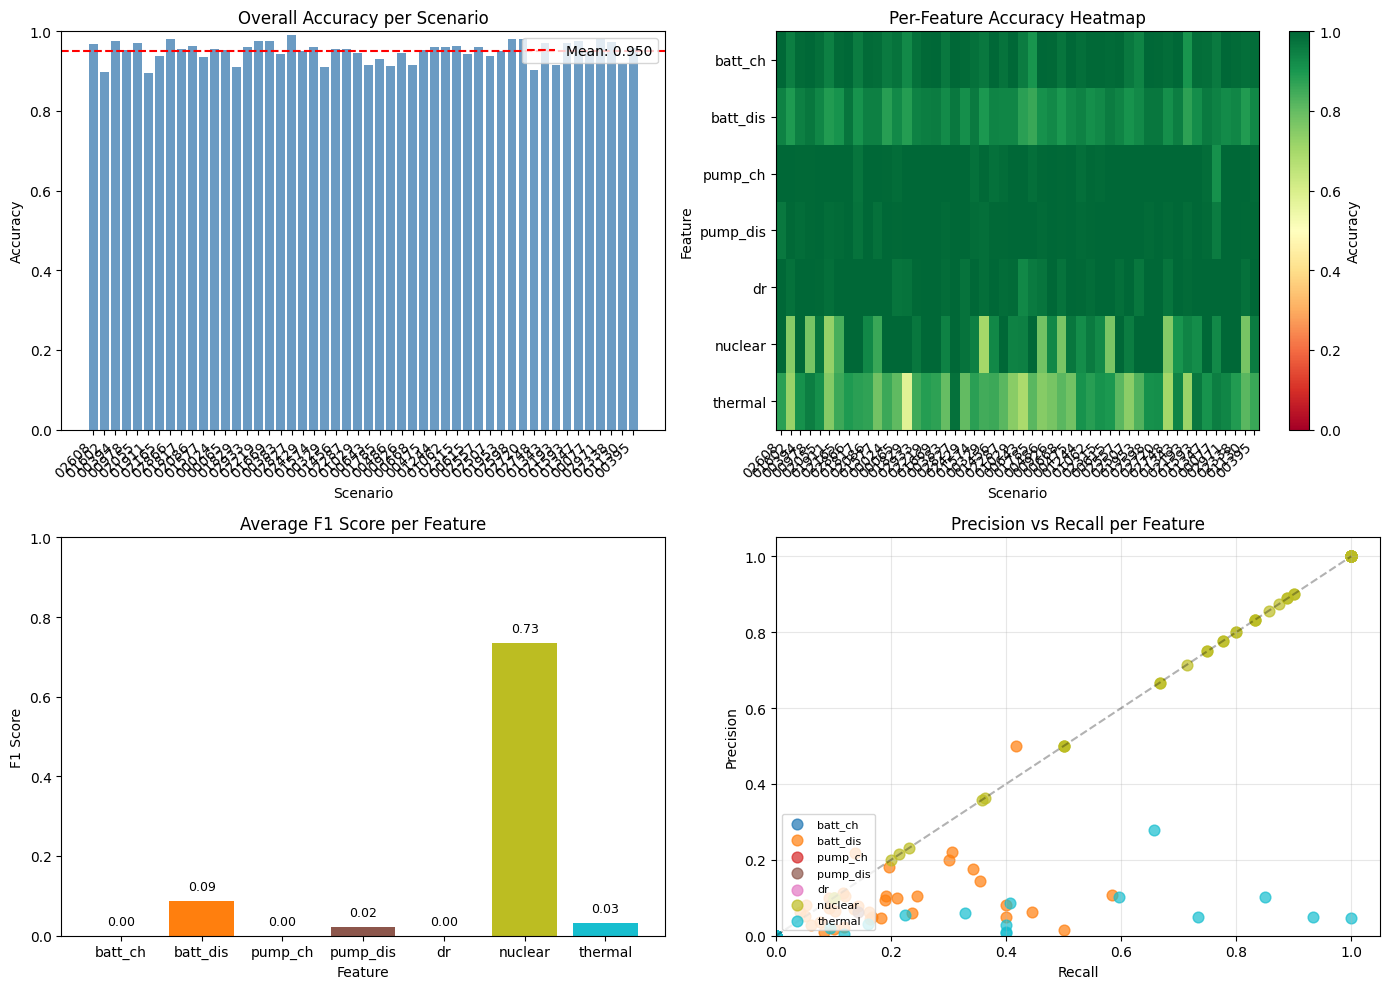


✅ Comparison visualization saved to /content/drive/MyDrive/benchmark/outputs/ebm_models/decoder_vs_milp_comparison.png


In [ ]:
# ==============================================================================
# VISUALIZE COMPARISON RESULTS
# ==============================================================================

if len(comparison_results) > 0:

    # Summary statistics
    print("=" * 80)
    print("SUMMARY STATISTICS")
    print("=" * 80)

    avg_accuracy = np.mean([r['accuracy'] for r in comparison_results])
    avg_hamming = np.mean([r['hamming_distance'] for r in comparison_results])

    print(f"\n📈 Overall Performance (n={len(comparison_results)} scenarios):")
    print(f"   Mean Accuracy: {avg_accuracy:.3f}")
    print(f"   Mean Hamming Distance: {avg_hamming:.3f}")

    # Per-feature average metrics
    feature_names = ['batt_ch', 'batt_dis', 'pump_ch', 'pump_dis', 'dr', 'nuclear', 'thermal']

    print(f"\n📊 Per-Feature Performance:")
    print(f"   {'Feature':<12} {'Accuracy':>10} {'Precision':>10} {'Recall':>10} {'F1':>10}")
    print(f"   {'-'*12} {'-'*10} {'-'*10} {'-'*10} {'-'*10}")

    for feat in feature_names:
        avg_acc = np.mean([r['feature_metrics'][feat]['accuracy'] for r in comparison_results])
        avg_prec = np.mean([r['feature_metrics'][feat]['precision'] for r in comparison_results])
        avg_rec = np.mean([r['feature_metrics'][feat]['recall'] for r in comparison_results])
        avg_f1 = np.mean([r['feature_metrics'][feat]['f1'] for r in comparison_results])
        print(f"   {feat:<12} {avg_acc:>10.3f} {avg_prec:>10.3f} {avg_rec:>10.3f} {avg_f1:>10.3f}")

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. Accuracy per scenario
    ax1 = axes[0, 0]
    scenario_labels = [r['scenario_id'].replace('scenario_', '') for r in comparison_results]
    accuracies = [r['accuracy'] for r in comparison_results]
    bars = ax1.bar(range(len(accuracies)), accuracies, color='steelblue', alpha=0.8)
    ax1.axhline(y=avg_accuracy, color='red', linestyle='--', label=f'Mean: {avg_accuracy:.3f}')
    ax1.set_xlabel('Scenario')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Overall Accuracy per Scenario')
    ax1.set_xticks(range(len(scenario_labels)))
    ax1.set_xticklabels(scenario_labels, rotation=45, ha='right')
    ax1.legend()
    ax1.set_ylim(0, 1)

    # 2. Per-feature accuracy heatmap
    ax2 = axes[0, 1]
    feature_accs = np.array([
        [r['feature_metrics'][feat]['accuracy'] for feat in feature_names]
        for r in comparison_results
    ])
    im = ax2.imshow(feature_accs.T, aspect='auto', cmap='RdYlGn', vmin=0, vmax=1)
    ax2.set_yticks(range(len(feature_names)))
    ax2.set_yticklabels(feature_names)
    ax2.set_xticks(range(len(scenario_labels)))
    ax2.set_xticklabels(scenario_labels, rotation=45, ha='right')
    ax2.set_xlabel('Scenario')
    ax2.set_ylabel('Feature')
    ax2.set_title('Per-Feature Accuracy Heatmap')
    plt.colorbar(im, ax=ax2, label='Accuracy')

    # 3. Per-feature F1 scores (bar chart)
    ax3 = axes[1, 0]
    avg_f1s = [np.mean([r['feature_metrics'][feat]['f1'] for r in comparison_results])
               for feat in feature_names]
    colors = plt.cm.tab10(np.linspace(0, 1, len(feature_names)))
    ax3.bar(feature_names, avg_f1s, color=colors)
    ax3.set_xlabel('Feature')
    ax3.set_ylabel('F1 Score')
    ax3.set_title('Average F1 Score per Feature')
    ax3.set_ylim(0, 1)
    for i, v in enumerate(avg_f1s):
        ax3.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

    # 4. Precision vs Recall scatter
    ax4 = axes[1, 1]
    for feat, color in zip(feature_names, colors):
        precs = [r['feature_metrics'][feat]['precision'] for r in comparison_results]
        recs = [r['feature_metrics'][feat]['recall'] for r in comparison_results]
        ax4.scatter(recs, precs, label=feat, alpha=0.7, s=60, c=[color])
    ax4.plot([0, 1], [0, 1], 'k--', alpha=0.3)
    ax4.set_xlabel('Recall')
    ax4.set_ylabel('Precision')
    ax4.set_title('Precision vs Recall per Feature')
    ax4.set_xlim(0, 1.05)
    ax4.set_ylim(0, 1.05)
    ax4.legend(loc='lower left', fontsize=8)
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['output_dir'], 'decoder_vs_milp_comparison.png'), dpi=150)
    plt.show()

    print(f"\n✅ Comparison visualization saved to {CONFIG['output_dir']}/decoder_vs_milp_comparison.png")

else:
    print("❌ No comparison results to visualize")

## 12. LP Worker - Warm Start Optimization with Fixed Binaries

This section implements the following approach: a clean LP worker that takes decoder binary outputs as warm starts and solves the exact "MILP with binaries fixed" using HiGHS solver.

### Key Features:
- **Exact LP formulation**: MILP with binaries fixed to decoder values
- **Warm start**: Uses decoder outputs as initial values for continuous variables  
- **Same constraints**: Preserves all MILP constraints (ramping, SOC, capacity, etc.)
- **HiGHS solver**: Fast open-source LP solver
- **Comparable results**: Ensures fair comparison with original MILP

In [7]:
# ==============================================================================
# LP WORKER - MILP WITH FIXED BINARIES SOLVED AS LP
# ==============================================================================
# This module provides a clean LP worker that:
# 1. Takes decoder binary outputs (u_thermal, b_charge_mode, pumped_charge_mode, dr_active)
# 2. Builds the exact MILP model from src/MILP/model.py
# 3. Fixes binary variables to decoder values (converting MILP → LP)
# 4. Solves with HiGHS LP solver
# 5. Returns optimized continuous variables and objective value
# ==============================================================================

# Install HiGHS solver if not present
!pip install -q highspy pyomo

import os
import sys
import torch
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple, Optional, Any
from dataclasses import dataclass
from tqdm.auto import tqdm
import time

# Ensure repo path is in sys.path
if REPO_PATH not in sys.path:
    sys.path.insert(0, REPO_PATH)

# Import MILP modules
from src.milp.model import build_uc_model
from src.milp.scenario_loader import load_scenario_data

# Import Pyomo for LP solving
from pyomo.environ import (
    value, SolverFactory, Var, Binary,
    NonNegativeReals, Reals, Constraint
)
from pyomo.opt import TerminationCondition

print("✓ LP Worker dependencies loaded")

✓ LP Worker dependencies loaded


In [8]:
# ==============================================================================
# LP WORKER TWO-STAGE: HARD-FIX + SOFT REPAIR FALLBACK
# ==============================================================================
# This imports the new two-stage LP worker that implements:
#   Stage 1 (hard_fix): Fix all binaries from decoder, solve pure LP (fast)
#   Stage 2 (repair_20): Unfix K=20 critical vars with flip budget
#   Stage 3 (repair_100): Unfix K=100 critical vars with flip budget  
#   Stage 4 (full_soft): Full soft constraints as last resort
#
# Strategy C: Flip budget constraint limits total deviations from decoder
# ==============================================================================

from src.milp.lp_worker_two_stage import (
    LPWorkerTwoStage,
    TwoStageResult,
    SolveStage,
    run_lp_worker_batch_two_stage,
)

# Alias for backward compatibility with existing code
LPWorkerResult = TwoStageResult
LPWorkerSoftConstraints = LPWorkerTwoStage
LPWorkerFixedBinaries = LPWorkerTwoStage

print("✓ LPWorkerTwoStage imported from src.milp.lp_worker_two_stage")
print("  Stages: hard_fix → repair_20 → repair_100 → full_soft")
print("  Strategy: Flip budget (Strategy C) with escalating K")

✓ LPWorkerTwoStage imported from src.milp.lp_worker_two_stage
  Stages: hard_fix → repair_20 → repair_100 → full_soft
  Strategy: Flip budget (Strategy C) with escalating K


In [9]:
# ==============================================================================
# BATCH LP WORKER EXECUTION (Two-Stage version)
# ==============================================================================
# The run_lp_worker_batch_two_stage function is imported from the module.
# It provides detailed per-stage logging and statistics.
# ==============================================================================

print("✓ Batch LP worker function available: run_lp_worker_batch_two_stage")
print("  Returns List[TwoStageResult] with detailed per-stage metrics")
print("  Logs: stage_used, n_unfixed, slack progression, decoder_deviation, n_flips")

✓ Batch LP worker function available: run_lp_worker_batch_two_stage
  Returns List[TwoStageResult] with detailed per-stage metrics
  Logs: stage_used, n_unfixed, slack progression, decoder_deviation, n_flips


In [10]:
# ==============================================================================
# INITIALIZE LP WORKER TWO-STAGE AND TEST
# ==============================================================================

SCENARIOS_JSON_DIR = CONFIG['scenarios_dir']

print(f"📂 Scenarios directory: {SCENARIOS_JSON_DIR}")

# Initialize Two-Stage LP Worker with recommended parameters
lp_worker = LPWorkerTwoStage(
    scenarios_dir=SCENARIOS_JSON_DIR,
    solver_name='appsi_highs',
    # Stage acceptance criteria
    slack_tol_mwh=1.0,              # Accept if slack <= 1 MWh
    # Soft penalty for deviation from decoder
    deviation_penalty=10000.0,       # λ = 10,000 (strong push toward decoder)
    # Flip budgets (Strategy C)
    flip_budget_20=100,               # Max 10 flips for repair-20
    flip_budget_100=1000,              # Max 30 flips for repair-100
    # Time limits per stage
    time_limit_hard_fix=30.0,        # TL1 = 20s
    time_limit_repair_20=15.0,       # TL2 = 15s
    time_limit_repair_100=60.0,      # TL3 = 60s
    time_limit_full_soft=1200.0,      # TL4 = 120s
    # Temporal window for critical variable expansion
    temporal_window=1,               # ±1 timestep neighbors
    verbose=False,
)

print(f"\n🧪 Testing LP worker with first scenario...")
test_sc_id = scenario_ids[0] if 'scenario_ids' in dir() else 'scenario_02608'
test_decoder_out = decoded_tensors[0] if 'decoded_tensors' in dir() and decoded_tensors[0] is not None else None

if test_decoder_out is not None:
    test_result = lp_worker.solve(test_sc_id, test_decoder_out)
    print(f"   Scenario: {test_sc_id}")
    print(f"   Status: {test_result.status}")
    print(f"   Stage used: {test_result.stage_used.value}")
    print(f"   Objective: {test_result.objective_value:.2f}")
    print(f"   Solve time: {test_result.solve_time:.2f}s")
    print(f"   Slack used: {test_result.slack_used:.1f} MWh")
    print(f"   Decoder deviation: {test_result.decoder_deviation:.1f}")
    print(f"   Number of flips: {test_result.n_flips}")
    print(f"   Variables unfixed: {test_result.n_unfixed}")
    print(f"\n   Per-stage timing:")
    print(f"     Hard-fix: {test_result.time_hard_fix:.2f}s (slack={test_result.slack_hard_fix:.1f})")
    print(f"     Repair-20: {test_result.time_repair_20:.2f}s (slack={test_result.slack_repair_20:.1f})")
    print(f"     Repair-100: {test_result.time_repair_100:.2f}s (slack={test_result.slack_repair_100:.1f})")
    print(f"     Full-soft: {test_result.time_full_soft:.2f}s (slack={test_result.slack_full_soft:.1f})")
    print(f"   Message: {test_result.message}")
else:
    print("   ⚠️ No decoder output available")

📂 Scenarios directory: C:\Users\Dell\projects\multilayer_milp_gnn\benchmark\outputs\scenarios_v1_filtered
✓ LPWorkerTwoStage initialized
  Solver: appsi_highs
  Slack tolerance: 1.0 MWh (dt=1.0h)
  Deviation penalty (λ): 10000.0
  Flip budgets: K=20→100, K=100→1000, full_soft→None
  Time limits: TL1=30.0s, TL2=15.0s, TL3=60.0s, TL4=1200.0s

🧪 Testing LP worker with first scenario...
   Scenario: scenario_02608
   Status: optimal
   Stage used: repair_100
   Objective: 395717.34
   Solve time: 6.50s
   Slack used: 0.0 MWh
   Decoder deviation: 44.0
   Number of flips: 44
   Variables unfixed: 360

   Per-stage timing:
     Hard-fix: 1.66s (slack=inf)
     Repair-20: 1.62s (slack=inf)
     Repair-100: 2.42s (slack=0.0)
     Full-soft: 0.00s (slack=0.0)
   Message: Repair-100 OK: slack=0.0, flips=44


📊 Decoder output statistics:
   Total scenarios: 50
   Valid decoder outputs: 50
   Skipped (None): 0

🚀 Running LP worker on 50 scenarios with valid decoder outputs...

LP WORKER TWO-STAGE - Processing 50 scenarios



LP Worker Two-Stage:   0%|          | 0/50 [00:00<?, ?it/s]

  ✓ scenario_02608: repair_100 | obj=395717 | slack=0.0 | flips=44 | 6.71s
  ✓ scenario_01602: full_soft | obj=6601397 | slack=0.9 | flips=400 | 45.91s
  ✓ scenario_00394: full_soft | obj=1560614 | slack=0.0 | flips=87 | 21.80s
  ✓ scenario_00978: full_soft | obj=3800808 | slack=4489.0 | flips=91 | 46.11s
  ✓ scenario_02055: full_soft | obj=2158000 | slack=557.9 | flips=138 | 38.40s
  ✓ scenario_01911: full_soft | obj=7489994 | slack=159.9 | flips=427 | 47.13s
  ✓ scenario_02165: full_soft | obj=5815670 | slack=828.0 | flips=278 | 51.83s
  ✓ scenario_02866: hard_fix | obj=1537817 | slack=0.0 | flips=0 | 3.68s
  ✓ scenario_01817: full_soft | obj=918986 | slack=609.9 | flips=48 | 13.09s
  ✓ scenario_02086: full_soft | obj=1293374 | slack=0.0 | flips=182 | 32.05s
  ✓ scenario_01577: hard_fix | obj=1406158 | slack=0.0 | flips=0 | 2.25s
  ✓ scenario_00024: full_soft | obj=972856 | slack=11.0 | flips=168 | 31.26s
  ✓ scenario_00065: full_soft | obj=1444079 | slack=218.1 | flips=203 | 28.45s


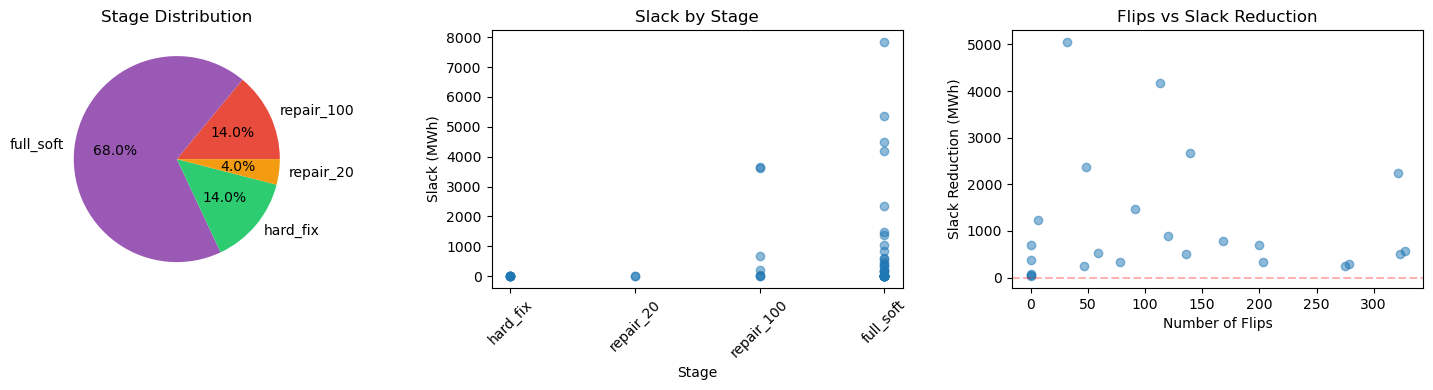


✅ Analysis saved to C:\Users\Dell\projects\multilayer_milp_gnn\benchmark\outputs\ebm_models/lp_two_stage_analysis.png


In [11]:
# ==============================================================================
# RUN LP WORKER TWO-STAGE ON DECODED SCENARIOS
# ==============================================================================

# Check if decoder outputs exist
if 'decoded_tensors' not in dir() or 'scenario_ids' not in dir():
    print("❌ Error: decoded_tensors or scenario_ids not found in memory.")
    print("   Please run Section 10-11 first to generate decoder outputs.")
    lp_results = []
elif lp_worker is None:
    print("❌ Error: lp_worker not initialized.")
    lp_results = []
else:
    # Filter to only scenarios with valid decoder outputs
    valid_indices = [i for i, dt in enumerate(decoded_tensors) if dt is not None]
    valid_scenario_ids = [scenario_ids[i] for i in valid_indices]
    valid_decoder_outputs = [decoded_tensors[i] for i in valid_indices]
    
    print(f"📊 Decoder output statistics:")
    print(f"   Total scenarios: {len(decoded_tensors)}")
    print(f"   Valid decoder outputs: {len(valid_indices)}")
    print(f"   Skipped (None): {len(decoded_tensors) - len(valid_indices)}")
    
    if len(valid_indices) == 0:
        print("❌ No valid decoder outputs found. Cannot run LP worker.")
        lp_results = []
    else:
        print(f"\n🚀 Running LP worker on {len(valid_indices)} scenarios with valid decoder outputs...")
        
        # Run two-stage LP worker on valid scenarios only
        lp_results = run_lp_worker_batch_two_stage(
            lp_worker=lp_worker,
            scenario_ids=valid_scenario_ids,
            decoder_outputs=valid_decoder_outputs,
            max_scenarios=None,  # Process all valid scenarios
        )
        
        # Additional analysis: stage distribution visualization
        if len(lp_results) > 0:
            import matplotlib.pyplot as plt
            
            stage_counts = {}
            for r in lp_results:
                stage = r.stage_used.value
                stage_counts[stage] = stage_counts.get(stage, 0) + 1
            
            # Plot stage distribution
            fig, axes = plt.subplots(1, 3, figsize=(15, 4))
            
            # 1. Stage distribution pie chart
            ax1 = axes[0]
            stages = list(stage_counts.keys())
            counts = [stage_counts[s] for s in stages]
            colors = {'hard_fix': '#2ecc71', 'repair_20': '#f39c12', 
                      'repair_100': '#e74c3c', 'full_soft': '#9b59b6', 'failed': '#7f8c8d'}
            ax1.pie(counts, labels=stages, autopct='%1.1f%%', 
                    colors=[colors.get(s, '#95a5a6') for s in stages])
            ax1.set_title('Stage Distribution')
            
            # 2. Slack vs Stage
            ax2 = axes[1]
            success_results = [r for r in lp_results if r.status in ['optimal', 'feasible_full_soft']]
            if success_results:
                slacks = [r.slack_used for r in success_results]
                stage_names = [r.stage_used.value for r in success_results]
                stage_order = ['hard_fix', 'repair_20', 'repair_100', 'full_soft']
                stage_to_x = {s: i for i, s in enumerate(stage_order)}
                x_vals = [stage_to_x.get(s, 4) for s in stage_names]
                ax2.scatter(x_vals, slacks, alpha=0.5)
                ax2.set_xticks(range(len(stage_order)))
                ax2.set_xticklabels(stage_order, rotation=45)
                ax2.set_xlabel('Stage')
                ax2.set_ylabel('Slack (MWh)')
                ax2.set_title('Slack by Stage')
            
            # 3. Number of flips vs Slack reduction
            ax3 = axes[2]
            if success_results:
                flips = [r.n_flips for r in success_results]
                slack_reduction = [r.slack_hard_fix - r.slack_used for r in success_results 
                                  if r.slack_hard_fix > 0]
                flips_filtered = [r.n_flips for r in success_results if r.slack_hard_fix > 0]
                if slack_reduction:
                    ax3.scatter(flips_filtered, slack_reduction, alpha=0.5)
                    ax3.set_xlabel('Number of Flips')
                    ax3.set_ylabel('Slack Reduction (MWh)')
                    ax3.set_title('Flips vs Slack Reduction')
                    ax3.axhline(y=0, color='r', linestyle='--', alpha=0.3)
            
            plt.tight_layout()
            plt.savefig(os.path.join(CONFIG['output_dir'], 'lp_two_stage_analysis.png'), dpi=150)
            plt.show()
            
            print(f"\n✅ Analysis saved to {CONFIG['output_dir']}/lp_two_stage_analysis.png")

In [23]:
# ==============================================================================
# COMPARE LP WORKER RESULTS WITH MILP GROUND TRUTH
# ==============================================================================

def load_milp_results(scenario_id: str, scenarios_dir: str) -> Tuple[Optional[float], Optional[float]]:
    """
    Load MILP objective and solve time from JSON report file.

    Returns: (objective, solve_seconds)
    """
    report_file = os.path.join(scenarios_dir, 'reports', f'{scenario_id}.json')
    print(report_file)
    if os.path.exists(report_file):
        print("exists")
        try:
            with open(report_file, 'r') as f:
                report = json.load(f)
                print(report)
                obj = report.get('mip', {}).get('objective')
                solve_time = report.get('mip', {}).get('solve_seconds')
                return obj, solve_time
        except:
            pass
    return None, None


# Compare LP worker results with MILP ground truth
if 'lp_results' in dir() and len(lp_results) > 0:
    print("\n" + "="*80)
    print("COMPARISON: LP WORKER vs MILP GROUND TRUTH")
    print("="*80 + "\n")

    comparison_data = []

    for result in lp_results:
        # Accept any non-failed status (was: only 'optimal')
        if result.status in ['error', 'infeasible']:
            continue

        milp_obj, milp_time = load_milp_results(result.scenario_id, SCENARIOS_JSON_DIR)

        comparison_data.append({
            'scenario_id': result.scenario_id,
            'lp_objective': result.objective_value,
            'milp_objective': milp_obj,
            'lp_solve_time': result.solve_time,
            'milp_solve_time': milp_time,
            'slack_used': result.slack_used,
            'decoder_deviation': result.decoder_deviation,
            'status': result.status,
            'stage': result.stage_used.name if result.stage_used else 'N/A',
        })

    if comparison_data:
        df_compare = pd.DataFrame(comparison_data)
        df_with_milp = df_compare[df_compare['milp_objective'].notna()].copy()

        if len(df_with_milp) > 0:
            # Calculate gaps
            df_with_milp['obj_gap_pct'] = 100 * (df_with_milp['lp_objective'] - df_with_milp['milp_objective']) / df_with_milp['milp_objective'].abs()
            df_with_milp['speedup'] = df_with_milp['milp_solve_time'] / df_with_milp['lp_solve_time']

            print(f"📊 Comparison Results (n={len(df_with_milp)} scenarios with MILP reference):")

            # Objective comparison
            print(f"\n🎯 OBJECTIVE VALUE:")
            print(f"   LP Objective:    mean={df_with_milp['lp_objective'].mean():.2f}")
            print(f"   MILP Objective:  mean={df_with_milp['milp_objective'].mean():.2f}")
            print(f"   Gap (%):         mean={df_with_milp['obj_gap_pct'].mean():.2f}%, median={df_with_milp['obj_gap_pct'].median():.2f}%, min={df_with_milp['obj_gap_pct'].min():.2f}%, max={df_with_milp['obj_gap_pct'].max():.2f}%")

            # Solve time comparison
            print(f"\n⏱️ SOLVE TIME:")
            print(f"   LP Solve (s):    mean={df_with_milp['lp_solve_time'].mean():.2f}, median={df_with_milp['lp_solve_time'].median():.2f}")
            print(f"   MILP Solve (s):  mean={df_with_milp['milp_solve_time'].mean():.2f}, median={df_with_milp['milp_solve_time'].median():.2f}")
            print(f"   Speedup (x):     mean={df_with_milp['speedup'].mean():.1f}x, median={df_with_milp['speedup'].median():.1f}x")

            # Total time savings
            total_lp_time = df_with_milp['lp_solve_time'].sum()
            total_milp_time = df_with_milp['milp_solve_time'].sum()
            time_saved = total_milp_time - total_lp_time
            print(f"\n⚡ TOTAL TIME:")
            print(f"   LP total:        {total_lp_time:.1f}s")
            print(f"   MILP total:      {total_milp_time:.1f}s")
            print(f"   Time saved:      {time_saved:.1f}s ({100*time_saved/total_milp_time:.1f}%)")

            # Stage distribution
            print(f"\n📈 STAGE DISTRIBUTION:")
            print(df_with_milp['stage'].value_counts().to_string())

            # Show detailed results
            print(f"\n📋 Detailed Results (first 50):")
            display_cols = ['scenario_id', 'lp_objective', 'milp_objective', 'obj_gap_pct', 'lp_solve_time', 'milp_solve_time', 'speedup', 'stage']
            print(df_with_milp[display_cols].head(50).to_string(index=False))

            # Store for visualization
            comparison_df = df_with_milp

        else:
            print("⚠️ No MILP reference objectives found for comparison")
            print(f"\n📋 LP Worker Results (first 10):")
            display_cols = ['scenario_id', 'lp_objective', 'lp_solve_time', 'status', 'stage']
            print(df_compare[display_cols].head(10).to_string(index=False))
    else:
        print("⚠️ No valid LP results to compare")


COMPARISON: LP WORKER vs MILP GROUND TRUTH

C:\Users\Dell\projects\multilayer_milp_gnn\benchmark\outputs\scenarios_v1_filtered\reports\scenario_02608.json
exists
C:\Users\Dell\projects\multilayer_milp_gnn\benchmark\outputs\scenarios_v1_filtered\reports\scenario_01602.json
exists
C:\Users\Dell\projects\multilayer_milp_gnn\benchmark\outputs\scenarios_v1_filtered\reports\scenario_00394.json
exists
C:\Users\Dell\projects\multilayer_milp_gnn\benchmark\outputs\scenarios_v1_filtered\reports\scenario_00978.json
exists
C:\Users\Dell\projects\multilayer_milp_gnn\benchmark\outputs\scenarios_v1_filtered\reports\scenario_02055.json
exists
C:\Users\Dell\projects\multilayer_milp_gnn\benchmark\outputs\scenarios_v1_filtered\reports\scenario_01911.json
exists
C:\Users\Dell\projects\multilayer_milp_gnn\benchmark\outputs\scenarios_v1_filtered\reports\scenario_02165.json
exists
C:\Users\Dell\projects\multilayer_milp_gnn\benchmark\outputs\scenarios_v1_filtered\reports\scenario_02866.json
exists
C:\Users\De

In [ ]:
# ==============================================================================
# COMPARE LP WORKER RESULTS WITH MILP GROUND TRUTH
# ==============================================================================
import json
import os

def load_milp_results(scenario_id: str, scenarios_dir: str) -> Tuple[Optional[float], Optional[float]]:
    """
    Load MILP objective and solve time from JSON report file.

    Returns: (objective, solve_seconds)
    """
    report_file = os.path.join(scenarios_dir, 'reports', f'{scenario_id}.json')
    if os.path.exists(report_file):
        try:
            with open(report_file, 'r') as f:
                report = json.load(f)
                obj = report.get('mip', {}).get('objective')
                solve_time = report.get('mip', {}).get('solve_seconds')
                return obj, solve_time
        except Exception as e:
            print(f"Error loading {report_file}: {e}")
    return None, None


# Compare LP worker results with MILP ground truth
if 'lp_results' in dir() and len(lp_results) > 0:
    print("\n" + "="*80)
    print("COMPARISON: LP WORKER vs MILP GROUND TRUTH")
    print("="*80 + "\n")

    # Use lp_worker's scenarios_dir (correct path for local/colab)
    if 'lp_worker' in dir():
        scenarios_dir_for_reports = lp_worker.scenarios_dir
    else:
        scenarios_dir_for_reports = SCENARIOS_JSON_DIR
    
    print(f"📂 Using scenarios_dir: {scenarios_dir_for_reports}")
    print(f"   Reports path: {os.path.join(scenarios_dir_for_reports, 'reports')}")
    print(f"   Path exists: {os.path.exists(os.path.join(scenarios_dir_for_reports, 'reports'))}\n")

    comparison_data = []

    for result in lp_results:
        # Accept any non-failed status
        if result.status in ['error', 'infeasible']:
            continue

        milp_obj, milp_time = load_milp_results(result.scenario_id, scenarios_dir_for_reports)

        comparison_data.append({
            'scenario_id': result.scenario_id,
            'lp_objective': result.objective_value,
            'milp_objective': milp_obj,
            'lp_solve_time': result.solve_time,
            'milp_solve_time': milp_time,
            'slack_used': result.slack_used,
            'decoder_deviation': result.decoder_deviation,
            'status': result.status,
            'stage': result.stage_used.name if result.stage_used else 'N/A',
        })

    if comparison_data:
        df_compare = pd.DataFrame(comparison_data)
        df_with_milp = df_compare[df_compare['milp_objective'].notna()].copy()

        if len(df_with_milp) > 0:
            # Calculate gaps
            df_with_milp['obj_gap_pct'] = 100 * (df_with_milp['lp_objective'] - df_with_milp['milp_objective']) / df_with_milp['milp_objective'].abs()
            df_with_milp['speedup'] = df_with_milp['milp_solve_time'] / df_with_milp['lp_solve_time']

            print(f"📊 Comparison Results (n={len(df_with_milp)} scenarios with MILP reference):")

            # Objective comparison
            print(f"\n🎯 OBJECTIVE VALUE:")
            print(f"   LP Objective:    mean={df_with_milp['lp_objective'].mean():.2f}")
            print(f"   MILP Objective:  mean={df_with_milp['milp_objective'].mean():.2f}")
            print(f"   Gap (%):         mean={df_with_milp['obj_gap_pct'].mean():.2f}%, median={df_with_milp['obj_gap_pct'].median():.2f}%, min={df_with_milp['obj_gap_pct'].min():.2f}%, max={df_with_milp['obj_gap_pct'].max():.2f}%")

            # Solve time comparison
            print(f"\n⏱️ SOLVE TIME:")
            print(f"   LP Solve (s):    mean={df_with_milp['lp_solve_time'].mean():.2f}, median={df_with_milp['lp_solve_time'].median():.2f}")
            print(f"   MILP Solve (s):  mean={df_with_milp['milp_solve_time'].mean():.2f}, median={df_with_milp['milp_solve_time'].median():.2f}")
            print(f"   Speedup (x):     mean={df_with_milp['speedup'].mean():.1f}x, median={df_with_milp['speedup'].median():.1f}x")

            # Total time savings
            total_lp_time = df_with_milp['lp_solve_time'].sum()
            total_milp_time = df_with_milp['milp_solve_time'].sum()
            time_saved = total_milp_time - total_lp_time
            print(f"\n⚡ TOTAL TIME:")
            print(f"   LP total:        {total_lp_time:.1f}s")
            print(f"   MILP total:      {total_milp_time:.1f}s")
            print(f"   Time saved:      {time_saved:.1f}s ({100*time_saved/total_milp_time:.1f}%)")

            # Stage distribution
            print(f"\n📈 STAGE DISTRIBUTION:")
            print(df_with_milp['stage'].value_counts().to_string())

            # Show detailed results
            print(f"\n📋 Detailed Results (first 50):")
            display_cols = ['scenario_id', 'lp_objective', 'milp_objective', 'obj_gap_pct', 'lp_solve_time', 'milp_solve_time', 'speedup', 'stage']
            print(df_with_milp[display_cols].head(50).to_string(index=False))

            # Store for visualization
            comparison_df = df_with_milp

        else:
            print("⚠️ No MILP reference objectives found for comparison")
            print(f"\n📋 LP Worker Results (first 10):")
            display_cols = ['scenario_id', 'lp_objective', 'lp_solve_time', 'status', 'stage']
            print(df_compare[display_cols].head(10).to_string(index=False))
    else:
        print("⚠️ No valid LP results to compare")


COMPARISON: LP WORKER vs MILP GROUND TRUTH

📂 Using scenarios_dir: C:\Users\Dell\projects\multilayer_milp_gnn\benchmark\outputs\scenarios_v1_filtered
   Reports path: C:\Users\Dell\projects\multilayer_milp_gnn\benchmark\outputs\scenarios_v1_filtered\reports
   Path exists: True

Error loading C:\Users\Dell\projects\multilayer_milp_gnn\benchmark\outputs\scenarios_v1_filtered\reports\scenario_02608.json: name 'json' is not defined
Error loading C:\Users\Dell\projects\multilayer_milp_gnn\benchmark\outputs\scenarios_v1_filtered\reports\scenario_01602.json: name 'json' is not defined
Error loading C:\Users\Dell\projects\multilayer_milp_gnn\benchmark\outputs\scenarios_v1_filtered\reports\scenario_00394.json: name 'json' is not defined
Error loading C:\Users\Dell\projects\multilayer_milp_gnn\benchmark\outputs\scenarios_v1_filtered\reports\scenario_00978.json: name 'json' is not defined
Error loading C:\Users\Dell\projects\multilayer_milp_gnn\benchmark\outputs\scenarios_v1_filtered\reports\sc

In [273]:
# ==============================================================================
# SAVE LP WORKER RESULTS
# ==============================================================================

import json
from datetime import datetime

if 'lp_results' in dir() and len(lp_results) > 0:

    # Prepare results for saving
    results_summary = {
        'timestamp': datetime.now().isoformat(),
        'solver': lp_worker.solver_name,
        'n_scenarios': len(lp_results),
        'n_optimal': len([r for r in lp_results if r.status == 'optimal']),
        'n_infeasible': len([r for r in lp_results if r.status == 'infeasible']),
        'n_error': len([r for r in lp_results if r.status in ['error', 'skipped']]),
        'scenarios': []
    }

    for result in lp_results:
        scenario_data = {
            'scenario_id': result.scenario_id,
            'status': result.status,
            'objective_value': float(result.objective_value) if result.objective_value != float('inf') else None,
            'solve_time': result.solve_time,
            'message': result.message
        }
        results_summary['scenarios'].append(scenario_data)

    # Calculate summary stats
    optimal_results = [r for r in lp_results if r.status == 'optimal']
    if optimal_results:
        results_summary['mean_objective'] = float(np.mean([r.objective_value for r in optimal_results]))
        results_summary['mean_solve_time'] = float(np.mean([r.solve_time for r in optimal_results]))
        results_summary['feasibility_rate'] = len(optimal_results) / len(lp_results)

    # Save to JSON
    output_file = os.path.join(CONFIG['output_dir'], 'lp_worker_results.json')
    with open(output_file, 'w') as f:
        json.dump(results_summary, f, indent=2)

    print(f"\n{'='*80}")
    print("LP WORKER - FINAL SUMMARY")
    print(f"{'='*80}")
    print(f"\n✅ Results saved to: {output_file}")
    print(f"\n📊 Summary:")
    print(f"   Total scenarios processed: {results_summary['n_scenarios']}")
    print(f"   Optimal solutions:         {results_summary['n_optimal']} ({100*results_summary['n_optimal']/results_summary['n_scenarios']:.1f}%)")
    print(f"   Infeasible:                {results_summary['n_infeasible']} ({100*results_summary['n_infeasible']/results_summary['n_scenarios']:.1f}%)")
    print(f"   Errors/Skipped:            {results_summary['n_error']} ({100*results_summary['n_error']/results_summary['n_scenarios']:.1f}%)")

    if 'mean_objective' in results_summary:
        print(f"\n   Mean objective value:      {results_summary['mean_objective']:.2f}")
        print(f"   Mean solve time:           {results_summary['mean_solve_time']:.3f} seconds")
        print(f"   Feasibility rate:          {100*results_summary['feasibility_rate']:.1f}%")

    print(f"\n✅ LP Worker pipeline complete!")
    print(f"   The decoder binary outputs have been used to warm-start the LP")
    print(f"   with fixed binaries, preserving all MILP constraints (ramping,")
    print(f"   SOC dynamics, capacity limits, balance equations, etc.)")
else:
    print("❌ No LP results to save")


LP WORKER - FINAL SUMMARY

✅ Results saved to: /content/drive/MyDrive/benchmark/outputs/ebm_models/lp_worker_results.json

📊 Summary:
   Total scenarios processed: 50
   Optimal solutions:         50 (100.0%)
   Infeasible:                0 (0.0%)
   Errors/Skipped:            0 (0.0%)

   Mean objective value:      10315697.16
   Mean solve time:           55.656 seconds
   Feasibility rate:          100.0%

✅ LP Worker pipeline complete!
   The decoder binary outputs have been used to warm-start the LP
   with fixed binaries, preserving all MILP constraints (ramping,
   SOC dynamics, capacity limits, balance equations, etc.)
